## AI BOOTCAMP - Exercises Week 7 - Classification & SVM

### Question 1

This question should be answered using the [Weekly](https://rdrr.io/cran/ISLR/man/Weekly.html) data set, which is part of the `ISLR` package. This data is similar in nature to the `Smarket` data from this chapter’s lab, except that it contains 1,089 weekly returns for 21 years, from the beginning of 1990 to the end of 2010.

In [1]:
# Import standard Python data science libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import seaborn as sns
sns.set()

# Import classes from scikit-learn for logistic regression, LDA, QDA, and KNN classification
# Import convenience function for computing confusion matrices 
# Import OneHotEncoder and StandardScaler for data pre-processing
# Import Pipeline, ColumnTransformer to encapsulate pre-processing heterogenous data and fitting
# into a single estimator
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Load StatsModels API
# Note that if we wish to use R-style formulas, then we would use the StatsModels Formula API
import statsmodels.api as sm
import statsmodels.formula.api as smf

weekly_filepath = "Weekly.csv"
weekly = pd.read_csv(weekly_filepath)
weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


### (a) Produce some numerical and graphical summaries of the `Weekly` data. Do there appear to be any patterns?

In [2]:
weekly.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000
mean,2000.048669,0.150585,0.151079,0.147205,0.145818,0.139893,1.574618,0.149899
std,6.033182,2.357013,2.357254,2.360502,2.360279,2.361285,1.686636,2.356927
min,1990.000000,-18.195000,-18.195000,-18.195000,-18.195000,-18.195000,0.087465,-18.195000
25%,1995.000000,-1.154000,-1.154000,-1.158000,-1.158000,-1.166000,0.332022,-1.154000
50%,2000.000000,0.241000,0.241000,0.241000,0.238000,0.234000,1.002680,0.241000
75%,2005.000000,1.405000,1.409000,1.409000,1.409000,1.405000,2.053727,1.405000
max,2010.000000,12.026000,12.026000,12.026000,12.026000,12.026000,9.328214,12.026000


In [3]:
weekly["Direction"].value_counts()

Up      605
Down    484
Name: Direction, dtype: int64

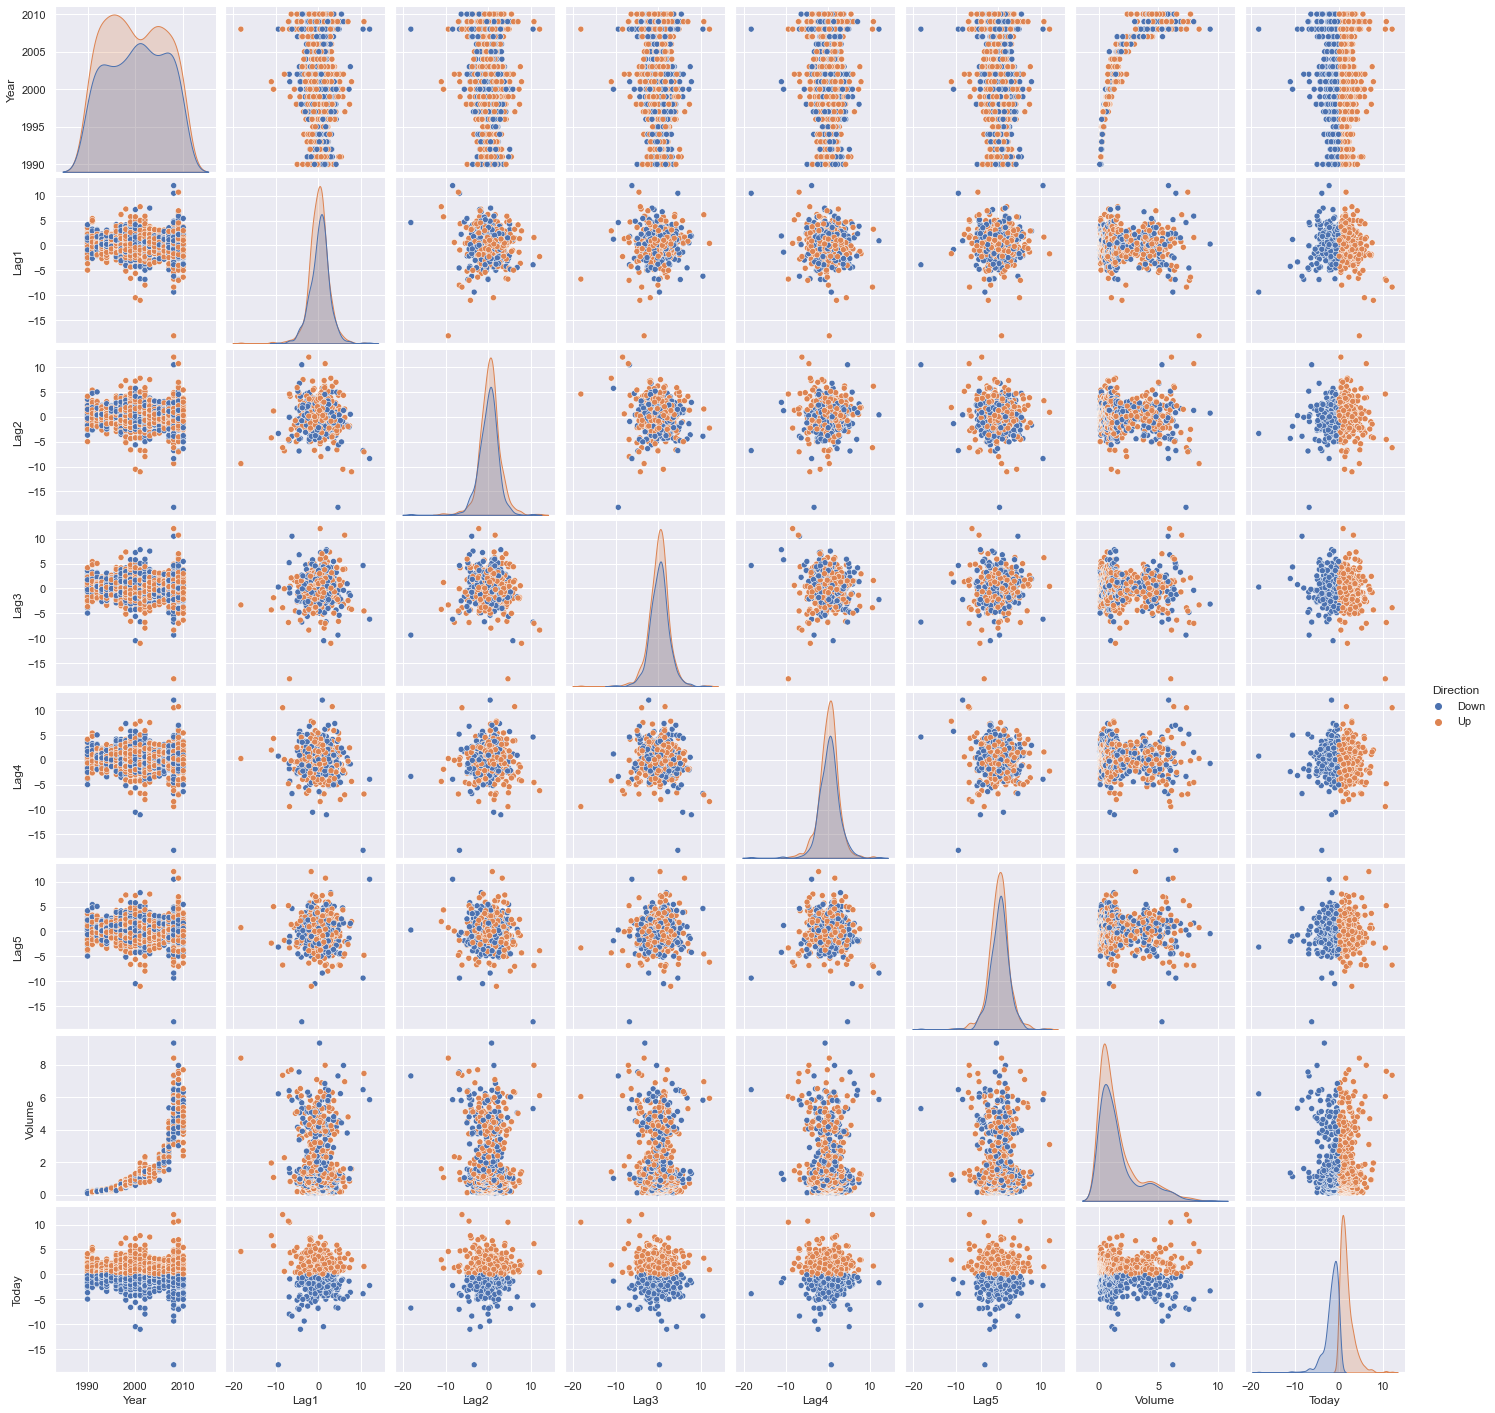

In [4]:
sns.pairplot(weekly, hue = "Direction");

From the initial summary statistics and scatterplot matrix, there don't appear to be any obvious patterns aside from the fact the volume of shares traded each week has grown quite a lot from 1990 to 2010. Looking more closely at the scatterplot of just volume over time, we can see that the number of shares traded each week has grown exponentially over the 21 years covered by the data.

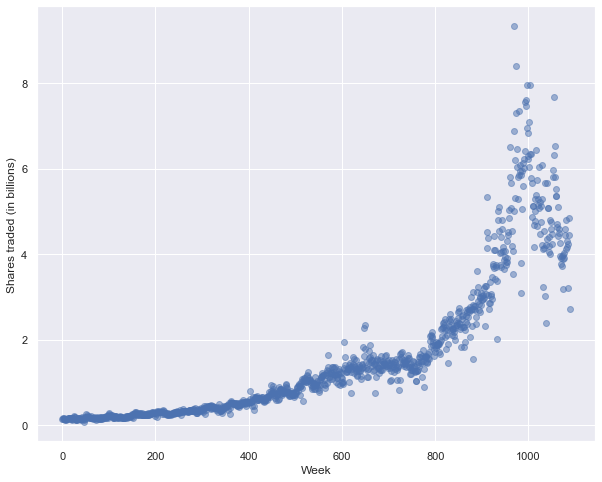

In [5]:
fig = plt.figure(figsize = (10, 8))
ax = plt.axes()
ax.scatter(x = weekly.index, y = weekly["Volume"], alpha = 0.5)
ax.set(xlabel = "Week", ylabel = "Shares traded (in billions)");

In [6]:
weekly.corr()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,-0.032289,-0.033390,-0.030006,-0.031128,-0.030519,0.841942,-0.032460
Lag1,-0.032289,1.000000,-0.074853,0.058636,-0.071274,-0.008183,-0.064951,-0.075032
Lag2,-0.033390,-0.074853,1.000000,-0.075721,0.058382,-0.072499,-0.085513,0.059167
Lag3,-0.030006,0.058636,-0.075721,1.000000,-0.075396,0.060657,-0.069288,-0.071244
Lag4,-0.031128,-0.071274,0.058382,-0.075396,1.000000,-0.075675,-0.061075,-0.007826
Lag5,-0.030519,-0.008183,-0.072499,0.060657,-0.075675,1.000000,-0.058517,0.011013
Volume,0.841942,-0.064951,-0.085513,-0.069288,-0.061075,-0.058517,1.000000,-0.033078
Today,-0.032460,-0.075032,0.059167,-0.071244,-0.007826,0.011013,-0.033078,1.000000


Lastly, we look at the matrix of correlations between the variables. Looking at the last row, we can see that each of the lag variables is only correlated very weakly with today's returns. The sole substantial value of 0.842, between Volume and Year, aligns with the strong correlation we saw in the above scatterplot.

###  (b) Use the full data set to perform a logistic regression with `Direction` as the response and the five lag variables plus `Volume` as predictors. Use the summary function to print the results. Do any of the predictors appear to be statistically significant? If so, which ones?

In [7]:
# Using the Logit class from StatsModels
# First encode response numerically
endog = (weekly["Direction"] == "Up").astype("int64")
exog = sm.add_constant(weekly.drop(columns = ["Direction", "Year", "Today"]))
logit_mod = sm.Logit(endog, exog)
logit_res = logit_mod.fit()
logit_res.summary()

Optimization terminated successfully.
         Current function value: 0.682441
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Direction   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1082
Method:                           MLE   Df Model:                            6
Date:                Thu, 30 Sep 2021   Pseudo R-squ.:                0.006580
Time:                        19:11:17   Log-Likelihood:                -743.18
converged:                       True   LL-Null:                       -748.10
Covariance Type:            nonrobust   LLR p-value:                    0.1313
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2669      0.086      3.106      0.002       0.098       0.435
Lag1          -0.0413      0.026     -1.563      0.118      -0.093       0.010
Lag2           0.0584      0.027      2.175      0.030       0.006       0.111
Lag3          -0.0161      0.027     -0.602      0.547      -0.068       0.036
Lag4          -0.0278      0.026     -1.050      0.294      -0.080       0.024
Lag5          -0.0145      0.026     -0.549      0.583      -0.066       0.037
Volume        -0.0227      0.037     -0.616      0.538      -0.095       0.050
==============================================================================
"""

The only statistically significant predictor is `Lag2`, with a *p*-value of 0.030 providing evidence at the 5% significance level to reject the null hypothesis that it is not related to the response `Direction` in favor of an association between `Lag2` and `Direction`. None of the other predictors are statistically significant, though `Lag1` is somewhat near the border of being significant at the 10% level, with a p-value of 0.118.

### (c) Compute the confusion matrix and overall fraction of correct predictions. Explain what the confusion matrix is telling you about the types of mistakes made by logistic regression.

In order to produce a confusion matrix that helps us better visualize the incorrect predictions, we use seaborn to convert the confusion matrix into a [heatmap](http://seaborn.pydata.org/generated/seaborn.heatmap.html?highlight=heatmap#seaborn.heatmap).

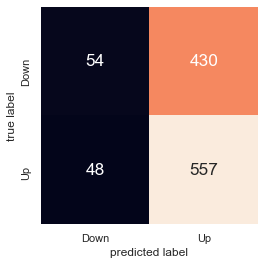

In [8]:
mat = pd.DataFrame(logit_res.pred_table(), columns = ["Down", "Up"], index = ["Down", "Up"])
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"})
ax.set(xlabel = "predicted label", ylabel = "true label");

In [9]:
logit_preds = pd.Series(logit_res.predict()).apply(lambda x: "Up" if (x > 0.5) else "Down")
(logit_preds == weekly["Direction"]).mean()

0.5610651974288338

As we can see in the confusion matrix, the logistic regression model using the five lag variables along with `Volume` as the predictors, and a prediction threshold of 0.5, correctly predicted 54 down weeks out of a total of 484 actual down weeks and 557 up days out of a total of 605 actual up weeks. This means that the model correctly predicted the direction for 611 weeks out of the 1089 for an accuracy of 0.5611. While this seems to be better than random chance, it is important to note that the model was trained on the entire data set, so 0.5611 is the *training* accuracy. Moreover, a naive strategy of simply saying that every week will be an up week would have resulted in 605 correctly predicted weeks out of 1089, which is a very similar level of overall accuracy.

To look a little closer at the confusion matrix, let's assume that our goal is to correctly predict when the market will go up. In this case, up weeks will be considered as positive ( $+$ ) and down weeks as negative ( $−$ ). Having set this convention, we can now consider four important quantities associated with the confusion matrix: true positive rate (i.e. sensitivity or recall), false positive rate, positive predictive value (i.e. precision), and negative predictive value. The true positive rate is the number of correctly predicted positives divided by the overall number of positives -- the number of correctly predicted up weeks (557) over the total number of up weeks (605) for a value of  $557/605≈0.92$  for this model. While this is a pretty high value, which is good, the false positive rate -- the number of incorrectly predicted positives (weeks incorrectly predicted to be up weeks = 430 weeks) divided by the overall number of negatives (the total number of down weeks = 484 weeks) -- is comparably high at  $430/484≈0.888$ , which might be quite bad depending on our sensitivity to losing money on an incorrectly predicted down week. Next is the positive predictive value, which is the number of true positives divided by the total number of predicted positives; in our case this is  $557/987≈0.564$ . This is better than chance, but as already noted we would have a comparable positive predictive value if we just predicted that every week would be an up week. Lastly is the negative predictive value, which is the number of true negatives divided by the total number of predicted negatives; in our case this is  $54/102≈0.529$ .

### (d) Now fit the logistic regression model using a training data period from 1990 to 2008, with `Lag2` as the only predictor. Compute the confusion matrix and the overall fraction of correct predictions for the held out data (that is, the data from 2009 and 2010).

In [10]:
train_mask = (weekly["Year"] < 2009)

In [11]:
# Using the Logit class from StatsModels
# First encode response numerically
train_endog = (weekly.loc[train_mask, "Direction"] == "Up").astype("int64")
train_exog = sm.add_constant(weekly.loc[train_mask, "Lag2"])
logit_mod = sm.Logit(train_endog, train_exog)
logit_res = logit_mod.fit()
logit_res.summary()

Optimization terminated successfully.
         Current function value: 0.685555
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Direction   No. Observations:                  985
Model:                          Logit   Df Residuals:                      983
Method:                           MLE   Df Model:                            1
Date:                Thu, 30 Sep 2021   Pseudo R-squ.:                0.003076
Time:                        19:11:17   Log-Likelihood:                -675.27
converged:                       True   LL-Null:                       -677.35
Covariance Type:            nonrobust   LLR p-value:                   0.04123
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2033      0.064      3.162      0.002       0.077       0.329
Lag2           0.0581      0.029      2.024      0.043       0.002       0.114
==============================================================================
"""

In [12]:
#use the model to predict test values
test_exog = sm.add_constant(weekly.loc[~train_mask, "Lag2"])
test_endog = weekly.loc[~train_mask, "Direction"]
logit_test_probs = logit_res.predict(test_exog)
logit_test_preds = pd.Series(logit_test_probs).apply(lambda x: "Up" if (x > 0.5) else "Down")

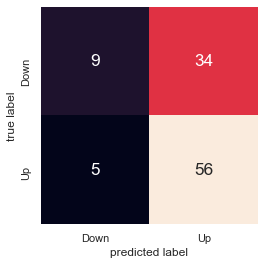

In [13]:
#evaluate the prediction
mat = pd.DataFrame(confusion_matrix(test_endog, logit_test_preds), columns = ["Down", "Up"], index = ["Down", "Up"])
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"})
ax.set(xlabel = "predicted label", ylabel = "true label");

In [14]:
(logit_test_preds == weekly.loc[~train_mask, "Direction"]).mean()

0.625

In [15]:
(weekly.loc[~train_mask, "Direction"] == "Up").mean()

0.5865384615384616

After fitting a logistic regression model on the data from 1990 through 2008 using only Lag2 as the predictor, the model correctly predicted the market direction for 62.5% of the weeks in the held-out data (the data from 2009 and 2010). While this is better than chance, it still is less than a 10% improvement over naively predicting that every week will be an up week. Continuing with the convention from Part 3 that an up week is a positive result, the true positive rate is  $56/61≈0.918$ , while the false positive rate is  $34/43≈0.791$ . In addition, the positive predictive value is  $56/90≈0.622$  and the negative predictive value is  $9/14≈0.643$ .

### (e) Repeat (d) using LDA.

In [16]:
# First separate out the training and test sets
X_train = weekly.loc[train_mask, "Lag2"].to_frame()
y_train = weekly.loc[train_mask, "Direction"]
X_test = weekly.loc[~train_mask, "Lag2"].to_frame()
y_test = weekly.loc[~train_mask, "Direction"]

In [17]:
# Fit the LDA model using the training set
lda_clf = LinearDiscriminantAnalysis()
lda_clf.fit(X_train, y_train)

LinearDiscriminantAnalysis()

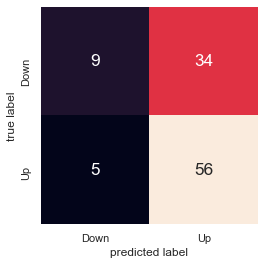

In [18]:
# Make predictions on test data and evaluate the fit
y_pred = lda_clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = lda_clf.classes_, yticklabels = lda_clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [19]:
lda_clf.score(X_test, y_test)

0.625

After performing linear discriminant analysis on the data from 1990 through 2008 using only `Lag2` as the predictor, we ended up with an identical confusion matrix to the one from part (d) with the logistic regression model. As we saw in part (d), the model correctly predicted the market direction for 62.5% of the weeks in the held-out data (the data from 2009 and 2010). While this is better than chance, it still is less than a 10% improvement over naively predicting that every week will be an up week. Continuing with the convention from part (c) that an up week is a positive result, the true positive rate is  $56/61≈0.918$ , while the false positive rate is  $34/43≈0.791$ . In addition, the positive predictive value is  $56/90≈0.622$  and the negative predictive value is  $9/14≈0.643$ .

### (f) Repeat (d) using QDA.

In [20]:
# First separate out the training and test sets
X_train = weekly.loc[train_mask, "Lag2"].to_frame()
y_train = weekly.loc[train_mask, "Direction"]
X_test = weekly.loc[~train_mask, "Lag2"].to_frame()
y_test = weekly.loc[~train_mask, "Direction"]

# Fit the QDA model using the training set
qda_clf = QuadraticDiscriminantAnalysis()
qda_clf.fit(X_train, y_train)

QuadraticDiscriminantAnalysis()

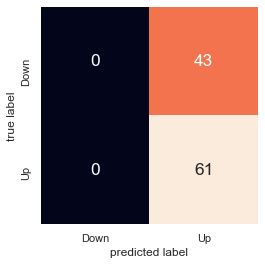

In [21]:
# Make predictions on test data and evaluate the fit
y_pred = qda_clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = qda_clf.classes_, yticklabels = qda_clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [22]:
qda_clf.score(X_test, y_test)

0.5865384615384616

After performing quadratic discriminant analysis on the data from 1990 through 2008 using only `Lag2` as the predictor, we ended up with a model that ended up predicting that every week in 2009 and 2010 would be an up week. The model correctly predicted the market direction for 58.7% of the weeks in the held-out data (the data from 2009 and 2010). While this is better than chance, it is the same result one would get from naively predicting that every week will be an up week, so to better compare the performance of this model to the logistic regression and linear discriminant analysis models testing on a larger test set would be necessary. Continuing with the convention from part (c) that an up week is a positive result, the true positive rate is  $61/61=1$ , while the false positive rate is  $43/43≈1$ . In addition, the positive predictive value is  $61/104≈0.587$  and since there were no negative predictions discussing the negative predictive value is meaningless.

### (g) Repeat (d) using KNN with K = 1.

In [23]:
# First separate out the training and test sets
X_train = weekly.loc[train_mask, "Lag2"].to_frame()
y_train = weekly.loc[train_mask, "Direction"]
X_test = weekly.loc[~train_mask, "Lag2"].to_frame()
y_test = weekly.loc[~train_mask, "Direction"]

# Set NumPy random seed for consistency and reproducibility of our results
np.random.seed(312)

# Fit the QDA model using the training set
knn_1_clf = KNeighborsClassifier(n_neighbors = 1)
knn_1_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

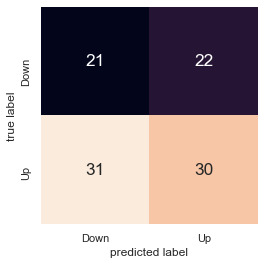

In [24]:
# Make predictions on test data and evaluate the fit
y_pred = knn_1_clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = qda_clf.classes_, yticklabels = qda_clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [25]:
knn_1_clf.score(X_test, y_test)

0.49038461538461536

After performing  *k*-nearest neighbors classification with  *k*=1  on the data from 1990 through 2008 using only `Lag2` as the predictor, the model correctly predicted the market direction for 49% of the weeks in the held-out data (the data from 2009 and 2010). While this essentially only as good as picking the direction randomly, it had worse performance than naively predicting that every week will be an up week. Continuing with the convention from part (c) that an up week is a positive result, the true positive rate is  $30/61≈0.492$ , while the false positive rate is  $22/43≈0.512$ . In addition, the positive predictive value is  $30/52≈0.577$  and the negative predictive value is  $21/52≈0.404$ .

### (h) Which of these methods appears to provide the best results on this data?

If we are only considering overall prediction accuracy, it appears that logistic regression and linear discriminant analysis were equally good as the models that performed the best on this data. Quadratic discriminant analysis came in third place, and  *k*-nearest neighbors with  *k*=1  a distant fourth. As noted above in part (g),  *k*-nearest neighbors didn't perform any better than randomly guessing, and in fact performed worse than naively predicting every week would be an up week. One thing that I would be cautious of, though, is the fact that aside from KNN, the other three models very strongly preferred to predict up weeks, and therefore had high false positive rates. This might be okay for an investor who is comfortable with taking more risks and has can afford losing money to down weeks that were incorrectly predicted to be up weeks, but a risk-averse investor would probably want to use a less aggressive model, or at least require a higher probability threshold than 50% before accepting a prediction of an up week.

In [26]:
d={'KNN':[knn_1_clf.score(X_test, y_test)],
   'LDA': [lda_clf.score(X_test, y_test)],
   'Logit': [(logit_test_preds == weekly.loc[~train_mask, "Direction"]).mean()], 
   'QDA': [qda_clf.score(X_test, y_test)]}
df = pd.DataFrame(data=d,index=["Accuracy"]).T.sort_values(by='Accuracy',ascending=False)
df

,Accuracy
LDA,0.625000
Logit,0.625000
QDA,0.586538
KNN,0.490385


### (i) Experiment with different combinations of predictors, including possible transformations and interactions, for each of the methods. Report the variables, method, and associated confusion matrix that appears to provide the best results on the held out data. Note that you should also experiment with values for K in the KNN classifier.

The combination of predictors I will try out is a weighted average of the lag variables where the recent lag values are weighted more heavily than the ones further in the past. More specifically, I will try out giving `Lag1` a weight of 40%, `Lag2` a weight of 35%, `Lag3` a weight of 15%, and `Lag4` and `Lag5` each weights of 5%. Note that I don't have a strong reason for these particular values of the weights aside from the intuitive assumption that recent weeks might be more-related to the direction of the current week than weeks that are further in the past. I just made it up.

In [27]:
weighted_lag_avg = 0.4*weekly["Lag1"] + 0.35*weekly["Lag2"] + 0.15*weekly["Lag3"] + 0.05*weekly["Lag4"] + 0.05*weekly["Lag5"]
weekly["weighted_lag_avg"] = weighted_lag_avg
weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction,weighted_lag_avg
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down,0.10055
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down,0.20515
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up,-1.12070
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up,0.58290
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up,1.15560


In [28]:
weekly[["Today", "weighted_lag_avg"]].corr()

,Today,weighted_lag_avg
Today,1.000000,-0.037241
weighted_lag_avg,-0.037241,1.000000


Computing the correlation between this weighted average and the value of the current week's return, we see that there only a very weak correlation between the two quantities. It is smaller in magnitude than the correlations between `Today` and the first the lag variables individually. That seems to suggest that this weighting might not be too useful, but I will still try out each of the classification methods using this transformation of the predictors. I will start out with logistic regression.

In [29]:
# Using the Logit class from StatsModels
# First encode response numerically
train_endog = (weekly.loc[train_mask, "Direction"] == "Up").astype("int64")
train_exog = sm.add_constant(weekly.loc[train_mask, "weighted_lag_avg"])
logit_mod = sm.Logit(train_endog, train_exog)
logit_res = logit_mod.fit()
logit_res.summary()

Optimization terminated successfully.
         Current function value: 0.687529
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Direction   No. Observations:                  985
Model:                          Logit   Df Residuals:                      983
Method:                           MLE   Df Model:                            1
Date:                Thu, 30 Sep 2021   Pseudo R-squ.:               0.0002054
Time:                        19:11:18   Log-Likelihood:                -677.22
converged:                       True   LL-Null:                       -677.35
Covariance Type:            nonrobust   LLR p-value:                    0.5978
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2135      0.064      3.312      0.001       0.087       0.340
weighted_lag_avg    -0.0282      0.053     -0.527      0.599      -0.133       0.077
====================================================================================
"""

In [30]:
test_exog = sm.add_constant(weekly.loc[~train_mask, "weighted_lag_avg"])
test_endog = weekly.loc[~train_mask, "Direction"]
logit_test_probs = logit_res.predict(test_exog)
logit_test_preds = pd.Series(logit_test_probs).apply(lambda x: "Up" if (x > 0.5) else "Down")

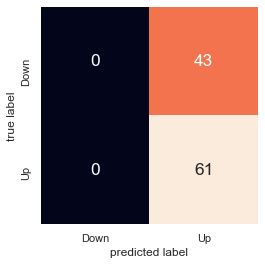

In [31]:
mat = pd.DataFrame(confusion_matrix(test_endog, logit_test_preds), columns = ["Down", "Up"], index = ["Down", "Up"])
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"})
ax.set(xlabel = "predicted label", ylabel = "true label");

In [32]:
(logit_test_preds == weekly.loc[~train_mask, "Direction"]).mean()

0.5865384615384616

As we can see, the results with logistic regression aren't particularly encouraing, as with a prediction threshold of 50% this method was equivalent to always predicting that the market would go up when evaluated on the test set. In addition, the *p*-value for the coefficient of `weighted_lag_avg` is 0.599, which means that there isn't evidence to say that it is statistically significant. Thinking a little more about the idea of using a weighted average, it makes sense that the performance with logistic regression won't provide an improvement over what we did in part (d), since the weighted average is still a linear combination of the variables. We already saw that in a logistic regression model, `Lag2` was the only statistically significant coefficient, and even then it is borderline at the 5% significance level, so the weighted average includes variables which we already had reason to believe weren't particularly helpful in making a strong model. I'll still try out the remaining methods with `weighted_lag_avg` before trying out one other combination of the predictors. Next up is linear discriminant analysis.

In [33]:
# First separate out the training and test sets
X_train = weekly.loc[train_mask, "weighted_lag_avg"].to_frame()
y_train = weekly.loc[train_mask, "Direction"]
X_test = weekly.loc[~train_mask, "weighted_lag_avg"].to_frame()
y_test = weekly.loc[~train_mask, "Direction"]

# Fit the LDA model using the training set
lda_clf = LinearDiscriminantAnalysis()
lda_clf.fit(X_train, y_train)

LinearDiscriminantAnalysis()

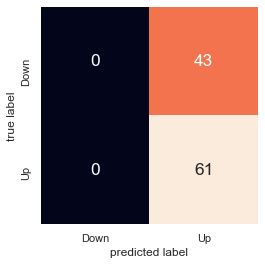

In [34]:
y_pred = lda_clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = lda_clf.classes_, yticklabels = lda_clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [35]:
lda_clf.score(X_test, y_test)

0.5865384615384616

Linear discriminant analysis has the same performance as logistic regression. This is reasonable since the two methods often perform similarly. Now we'll consider quadratic discriminant analysis.

In [36]:
# First separate out the training and test sets
X_train = weekly.loc[train_mask, "weighted_lag_avg"].to_frame()
y_train = weekly.loc[train_mask, "Direction"]
X_test = weekly.loc[~train_mask, "weighted_lag_avg"].to_frame()
y_test = weekly.loc[~train_mask, "Direction"]

# Fit the QDA model using the training set
qda_clf = QuadraticDiscriminantAnalysis()
qda_clf.fit(X_train, y_train)

QuadraticDiscriminantAnalysis()

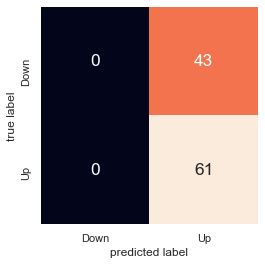

In [37]:
y_pred = qda_clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = qda_clf.classes_, yticklabels = qda_clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [38]:
qda_clf.score(X_test, y_test)

0.5865384615384616

In [39]:
qda_clf.predict_proba(X_test).max()

0.9435257061804728

Quadratic discriminant analysis also performed the same, but when checking the maximum value in the n-dimensional array of posterior probabilities, I noticed that the maximum probability from QDA is 0.943. This means that it could be meaningful to try out a stricter threshold for predicting an up week. I will try out a threshold of 60%.

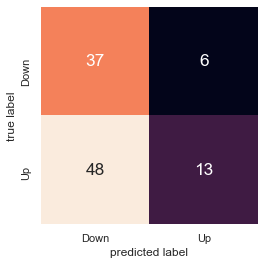

In [40]:
qda_predict_proba = qda_clf.predict_proba(X_test)
# Columns in the 2-dimensional array qda_predict_proba correspond to posterior probabilities
# for the classes, as found in qda_clf.classes_
# In this case, qda_clf.classes_ is the list ["Down", "Up"], so the index 1 column contains the 
# posterior probabilities for the class "Up"
y_pred_60 = pd.Series(qda_predict_proba[:, 1]).apply(lambda x: "Up" if (x > 0.6) else "Down")
mat = confusion_matrix(y_test, y_pred_60)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = qda_clf.classes_, yticklabels = qda_clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [41]:
(y_pred_60.values == y_test.values).mean()

0.4807692307692308

With a somewhat stricter probability threshold of 60% for predicting an up week, we see that our overall prediction accuracy goes down to 48.1%. However, our false positive rate is now  $6/43≈0.14$ , which is a big improvement over the false positive rate of 1 from part (f). In addition, our positive predictive value is  $13/19≈0.684$ , which is also an improvement over the value of 0.587 from part (f). This suggests that if we are risk-averse investors who only want to invest our money when there is a pretty good chance of the market going up, then QDA with our weighted average of the lag variables and a stricter probability threshold could be promising. Last up is  *k*-nearest neighbors.

In [42]:
# First separate out the training and test sets
X_train = weekly.loc[train_mask, "weighted_lag_avg"].to_frame()
y_train = weekly.loc[train_mask, "Direction"]
X_test = weekly.loc[~train_mask, "weighted_lag_avg"].to_frame()
y_test = weekly.loc[~train_mask, "Direction"]

# Set NumPy random seed for consistency and reproducibility of our results
np.random.seed(312)

# Fit the QDA model using the training set
knn_1_clf = KNeighborsClassifier(n_neighbors = 1)
knn_1_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

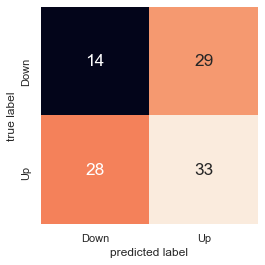

In [43]:
y_pred = knn_1_clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = qda_clf.classes_, yticklabels = qda_clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [44]:
knn_1_clf.score(X_test, y_test)

0.4519230769230769

With  *k*=1 , KNN performs even worse than random guessing when it comes to overall prediction accuracy, and the true positive rate (0.541), false positive rate (0.674), and positive predictive rate (0.532) aren't encouraging when compared to the result from part (h). Before moving on, let's try out two more values for  *k*: *k*=3 and *k*=5 .

In [45]:
# Set NumPy random seed for consistency and reproducibility of our results
np.random.seed(312)

# Fit the QDA model using the training set
knn_3_clf = KNeighborsClassifier(n_neighbors = 3)
knn_3_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

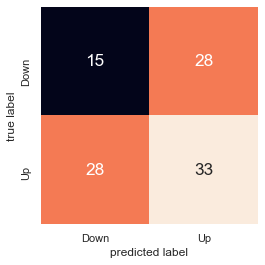

In [46]:
y_pred = knn_3_clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = qda_clf.classes_, yticklabels = qda_clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [47]:
knn_3_clf.score(X_test, y_test)

0.46153846153846156

In [48]:
# Set NumPy random seed for consistency and reproducibility of our results
np.random.seed(312)

# Fit the QDA model using the training set
knn_5_clf = KNeighborsClassifier(n_neighbors = 5)
knn_5_clf.fit(X_train, y_train)

KNeighborsClassifier()

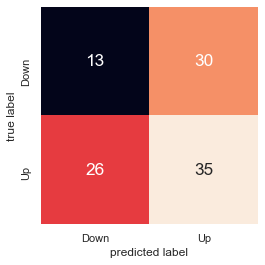

In [49]:
y_pred = knn_5_clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = qda_clf.classes_, yticklabels = qda_clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [50]:
knn_5_clf.score(X_test, y_test)

0.46153846153846156

Even when we increase the value of  *k* , the results are largely the same. While it would be best to compare these different models using additional tools, such as computing ROC curves and AUC scores for each model, I'll save that for later when we discuss how to produce them more in depth. For now, it looks like as far as using `weighted_lag_avg` to make predictions goes, the most-promising model is QDA with a prediction threshold of 60%.

If I have time to revisit this exercise in the future, I think it would be intersting to try out a different weighting strategy, where each lag variable is weighted based on the number of shares during the corresponding week of trading.

***

## Question 2

In this problem, you will develop a model to predict whether a given car gets high or low gas mileage based on the `Auto` data set.

In [51]:
auto = pd.read_csv("Auto.csv", na_values = ["?"]).dropna()
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


Note that the origin column actually contains categorical data, even though it is coded using integers. In order to make my life a little easier for performing regression, I'm going replace the values in that column with their meanings.

In [52]:
auto["origin"] = auto["origin"].map({1: "American", 2: "European", 3: "Japanese"})
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,American,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,American,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,American,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,American,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,American,ford torino


For this exercise, I will use scikit-learn for all of the parts out of convenience.

### (a) Create a binary variable, `mpg_med`, that contains `Above` if `mpg` contains a value above its median, and a `Below` if `mpg` contains a value below its median. You can compute the median using the `Series.median()` function. 

In [53]:
mpg_med = (auto["mpg"] > auto["mpg"].median()).map({False: "Below", True: "Above"})
auto["mpg_med"] = mpg_med
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg_med
0,18.0,8,307.0,130.0,3504,12.0,70,American,chevrolet chevelle malibu,Below
1,15.0,8,350.0,165.0,3693,11.5,70,American,buick skylark 320,Below
2,18.0,8,318.0,150.0,3436,11.0,70,American,plymouth satellite,Below
3,16.0,8,304.0,150.0,3433,12.0,70,American,amc rebel sst,Below
4,17.0,8,302.0,140.0,3449,10.5,70,American,ford torino,Below


### (b) Explore the data graphically in order to investigate the association between mpg01 and the other features. Which of the other features seem most likely to be useful in predicting `mpg_med`? Scatterplots and boxplots may be useful tools to answer this question. Describe your findings.

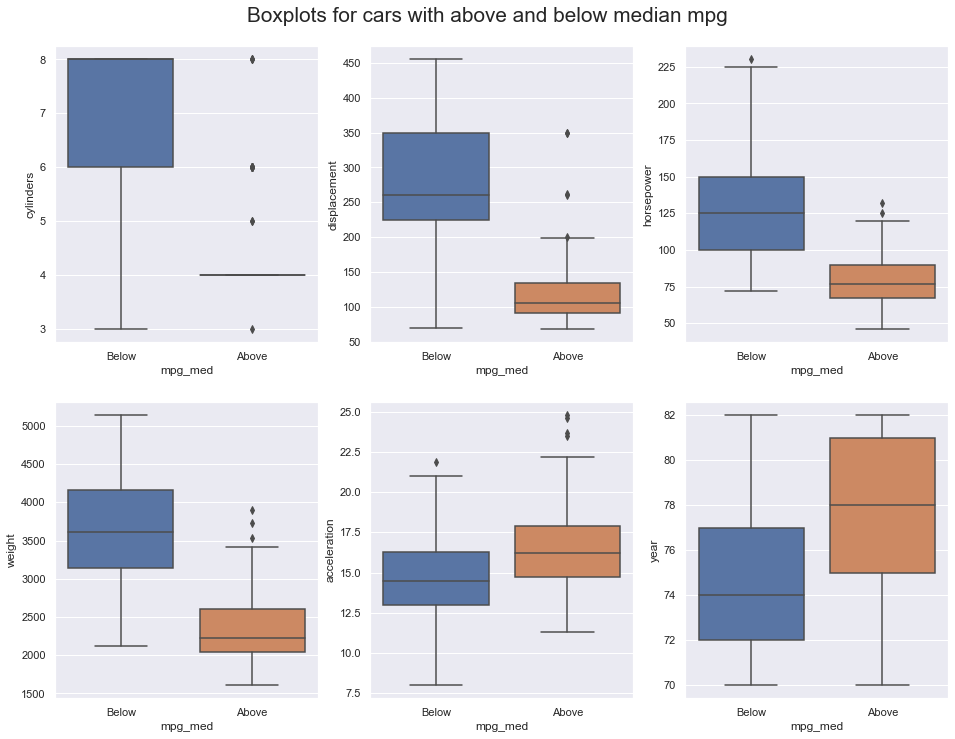

In [54]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (16, 12))
sns.boxplot(x = "mpg_med", y = "cylinders", data = auto, ax = axes[0, 0])
sns.boxplot(x = "mpg_med", y = "displacement", data = auto, ax = axes[0, 1])
sns.boxplot(x = "mpg_med", y = "horsepower", data = auto, ax = axes[0, 2])
sns.boxplot(x = "mpg_med", y = "weight", data = auto, ax = axes[1, 0])
sns.boxplot(x = "mpg_med", y = "acceleration", data = auto, ax = axes[1, 1])
sns.boxplot(x = "mpg_med", y = "year", data = auto, ax = axes[1, 2])
fig.suptitle("Boxplots for cars with above and below median mpg", size = "xx-large", y = 0.925);

First, I made boxplots to compare the overall distributions for each of the quantitative variables between cars with above-median mpg and those with below median-mpg. Starting in the upper-left corner, we see that aside from some outliers, the the majority of cars with above-median mpg have four-cylinder engines. Moving to the upper-middle pair of boxplots, at least 75% of the cars with above-median mpg have smaller engines than 75% of the cars with below-median mpg. This is also true for horsepower (upper-right pair of boxplots) and weight (lower-left pair of boxplots). We also see in the final two pairs of boxplots, for acceleration and manufacture year, that while there are definitely differences between cars with above-median mpg and those with below-median mpg, the differences aren't as strong compared to the first four predictors. In particular, there is a lot more overlap in both time to reach 60 mpg and manufacture year between the two categories of cars, whereas for the other predictors there is almost no overlap for the boxplots between the two categories. This suggests that `cylinders`, `displacement`, `horsepower`, and `weight` will be the most useful in predicting `mpg_med`.

D:\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warni

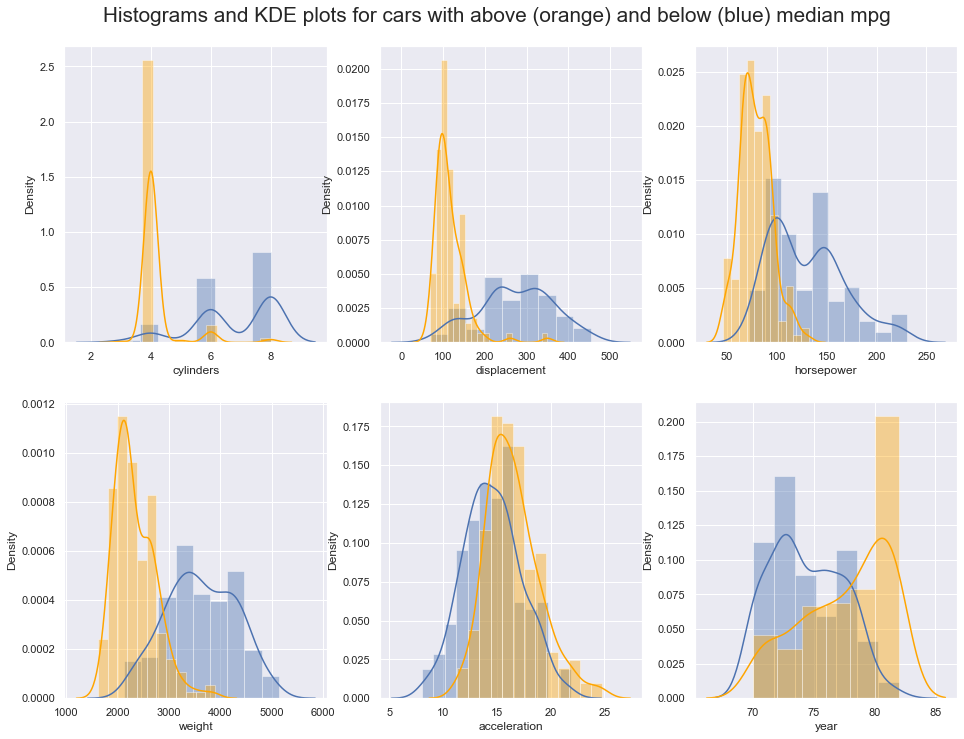

In [55]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (16, 12))
sns.distplot(auto.loc[auto["mpg_med"] == "Below", "cylinders"], ax = axes[0, 0])
sns.distplot(auto.loc[auto["mpg_med"] == "Above", "cylinders"], ax = axes[0, 0], color = "orange")
sns.distplot(auto.loc[auto["mpg_med"] == "Below", "displacement"], ax = axes[0, 1])
sns.distplot(auto.loc[auto["mpg_med"] == "Above", "displacement"], ax = axes[0, 1], color = "orange")
sns.distplot(auto.loc[auto["mpg_med"] == "Below", "horsepower"], ax = axes[0, 2])
sns.distplot(auto.loc[auto["mpg_med"] == "Above", "horsepower"], ax = axes[0, 2], color = "orange")
sns.distplot(auto.loc[auto["mpg_med"] == "Below", "weight"], ax = axes[1, 0])
sns.distplot(auto.loc[auto["mpg_med"] == "Above", "weight"], ax = axes[1, 0], color = "orange")
sns.distplot(auto.loc[auto["mpg_med"] == "Below", "acceleration"], ax = axes[1, 1])
sns.distplot(auto.loc[auto["mpg_med"] == "Above", "acceleration"], ax = axes[1, 1], color = "orange")
sns.distplot(auto.loc[auto["mpg_med"] == "Below", "year"], ax = axes[1, 2])
sns.distplot(auto.loc[auto["mpg_med"] == "Above", "year"], ax = axes[1, 2], color = "orange")
fig.suptitle("Histograms and KDE plots for cars with above (orange) and below (blue) median mpg",
             size = "xx-large", y = 0.925);

Looking at histograms overlaid with kernel density estimates we are better able to visualize the extent to which the distributions of the cars with above-median fuel economy overlap with the distributions of the cars with below-median fuel economy for each quantitative variable. This provides further evidence to suggest that horsepower and weight will be useful in predicting mpg_med, with decently clear separations between the distribution peaks between above-median and below-median cars. The plot involving `cylinders` seems to indicate that that variable wouldn't be as helpful on on its own. The small number of possibilities for the number of engine cylinders (3, 4, 5, 6, or 8) results in a lot of overlap, though there is a very prononunced peak that indicates a large number of cars with above-median fuel efficiency have four-cylinder engines. The significant overlap between groups for the acceleration plot is further evidence to suggest that acceleration will not be a variable that is helpful in predicting `mpg_med`.

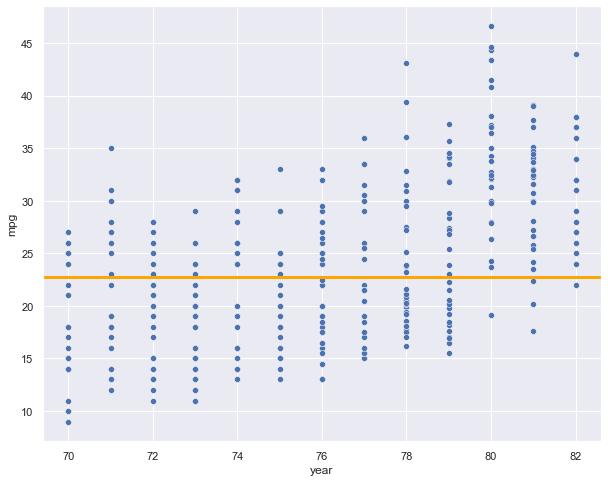

In [56]:
fig, ax = plt.subplots(figsize = (10, 8))
sns.scatterplot(x = "year", y = "mpg", data = auto, ax = ax)
ax.axhline(y = auto["mpg"].median(), color = "orange", linewidth = 3);

Next, the above scatterplot of `mpg` vs `year` also shows that the newer cars in the data set tend to be more fuel efficient. Therefore, while manufacture year might not be as useful as the other four quantitative variables, that stood out (`cylinders`, `displacement`, `horsepower` and `weight`), it still seems worth including.

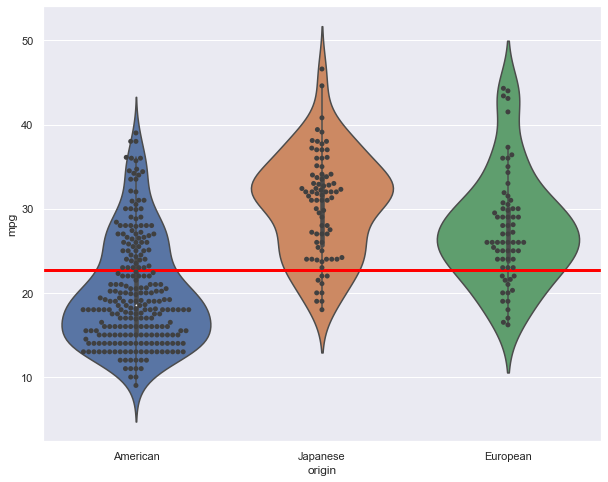

In [57]:
fig, ax = plt.subplots(figsize = (10, 8))
sns.violinplot(x = "origin", y = "mpg", data = auto, ax = ax)
sns.swarmplot(x = "origin", y = "mpg", data = auto, ax = ax, color = ".25")
ax.axhline(y = auto["mpg"].median(), color = "red", linewidth = 3);

Lastly, when looking at a violinplot overlaid with a swarmplot that compares the mpg values for each car, categorized by country of origin, we see that there is a clear difference between `American` cars, which tend to have below-median fuel efficiency, and `European` and `Japanese` cars, which tend to have above-median fuel efficiency. Thus, it seems that origin will also be useful in predicting `mpg_med`.

In conclusion, for the remaining parts I will use all of the predictors except for `acceleration` and `name` in my models for trying to predict mpg_med. Also, I will exclude `mpg` because that was directly used to create the classification label.

### (c) Split the data into a training set and a test set.

In [58]:
# a convenient function for splitting data sets
X_train, X_test, y_train, y_test = train_test_split(auto, auto["mpg_med"], test_size = 0.25, random_state = 312)

### (d) Perform LDA on the training data in order to predict `mpg_med` using the variables that seemed most associated with `mpg_med` in (b). What is the test error of the model obtained?

Before we start fitting models and estimating test errors, we make a note about the overall process we will use for model preprocessing and fitting. In order to encapsulate the preprocessing and fitting into a single estimator, we will make use of [pipelines](https://scikit-learn.org/stable/modules/compose.html#pipeline). The steps in our pipeline will be as follows.

1. Preprocessing
   1. Use the [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder) to encode the categorical column `origin`.
   2. When performing KNN or logistic regression with regularization, use the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) to standardize the numerical columns to have mean zero and variance one.
   3. Since we have heterogenous data types, we then combine the preprocessing for the categorical columns and numeric columns into a [ColumnTransformer](https://scikit-learn.org/stable/modules/compose.html#column-transformer). This page is an [example of how to use the ColumnTransformer class](https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html).
   4. If we are not standardizing the numerical columns, we pass them through without doing anything.
2. Combine the preprocessor with our choice of model estimator class (e.g. LogisticRegression, LinearDiscrminantAnalysis, etc.) into a single pipeline.

In [59]:
categorical_features = ["origin"]
categorical_transformer = Pipeline([("onehot", OneHotEncoder(drop = "first"))])
numerical_features = ["cylinders", "displacement", "horsepower", "weight", "year"]
preprocessor = ColumnTransformer([("cat", categorical_transformer, categorical_features),
                                 ("num", "passthrough", numerical_features)])
clf = Pipeline([("preprocessor", preprocessor), ("classifier", LinearDiscriminantAnalysis())])

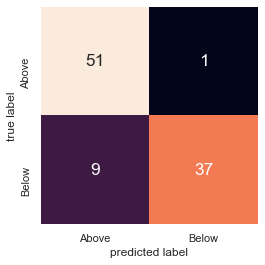

In [60]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf["classifier"].classes_, yticklabels = clf["classifier"].classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [61]:
1 - clf.score(X_test, y_test)

0.10204081632653061

When using linear discriminant analysis to predict `mpg_med` using `cylinders`, `displacement`, `horsepower`, `weight`, `year`, and `origin`, we had an overall test error of 10.2%. One thing of note is that this method only mis-classified one of the cars that actually had above-median fuel economy.

In [62]:
# Exclude the origin and year columns
categorical_features = []
categorical_transformer = Pipeline([("onehot", OneHotEncoder(drop = "first"))])
numerical_features = ["cylinders", "displacement", "horsepower", "weight"]
preprocessor = ColumnTransformer([("cat", categorical_transformer, categorical_features),
                                 ("num", "passthrough", numerical_features)])
clf = Pipeline([("preprocessor", preprocessor), ("classifier", LinearDiscriminantAnalysis())])

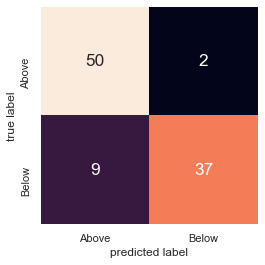

In [63]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf["classifier"].classes_, yticklabels = clf["classifier"].classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [64]:
1 - clf.score(X_test, y_test)

0.11224489795918369

If we exclude the `origin` and `year` variables, our overall test error increases very slightly to 11.2%.

### (d) Perform QDA on the training data in order to predict `mpg_med` using the variables that seemed most associated with `mpg_med` in (b). What is the test error of the model obtained?

In [65]:
categorical_features = ["origin"]
categorical_transformer = Pipeline([("onehot", OneHotEncoder(drop = "first"))])
numerical_features = ["cylinders", "displacement", "horsepower", "weight", "year"]
preprocessor = ColumnTransformer([("cat", categorical_transformer, categorical_features),
                                 ("num", "passthrough", numerical_features)])
clf = Pipeline([("preprocessor", preprocessor), ("classifier", QuadraticDiscriminantAnalysis())])

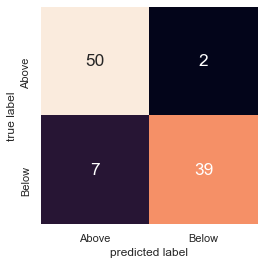

In [66]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf["classifier"].classes_, yticklabels = clf["classifier"].classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [67]:
1 - clf.score(X_test, y_test)

0.09183673469387754

When using quadratic discriminant analysis to predict `mpg_med` using `cylinders`, `displacement`, `horsepower`, `weight`, `year`, and `origin`, we had an overall test error of 9.18%, which is slight decrease compared to linear discriminant analysis using all of those predictors.

In [68]:
# Exclude the origin and year columns
categorical_features = []
categorical_transformer = Pipeline([("onehot", OneHotEncoder(drop = "first"))])
numerical_features = ["cylinders", "displacement", "horsepower", "weight"]
preprocessor = ColumnTransformer([("cat", categorical_transformer, categorical_features),
                                 ("num", "passthrough", numerical_features)])
clf = Pipeline([("preprocessor", preprocessor), ("classifier", QuadraticDiscriminantAnalysis())])

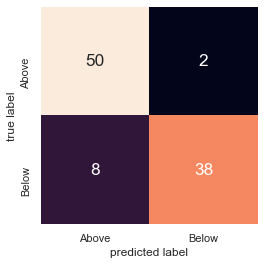

In [69]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf["classifier"].classes_, yticklabels = clf["classifier"].classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [70]:
1 - clf.score(X_test, y_test)

0.10204081632653061

If we exclude the `origin` and `year` variables, our overall test error slightly increases up to 10.2%. This is the same performance as linear discriminant analysis using all of the original predictors, though this model has a different confusion matrix. In particular, using the convention that above-median mpg is the positive class label, this model has a lower false positive rate ( $8/46≈0.174$  versus  $9/46≈0.196$ ), a lower true positive rate ( $50/52≈0.962$  versus  $51/52≈0.981$ ), a higher positive predictive value ( $50/58≈0.862$  versus  $51/60=0.85$ ), and a lower negative predictive value ( $38/40=0.95$  versus  $37/38≈0.974$ ).

### (e) Perform logistic regression on the training data in order to predict `mpg_med` using the variables that seemed most associated with `mpg_med` in (b). What is the test error of the model obtained?

In [71]:
categorical_features = ["origin"]
categorical_transformer = Pipeline([("onehot", OneHotEncoder(drop = "first"))])
numerical_features = ["cylinders", "displacement", "horsepower", "weight", "year"]
preprocessor = ColumnTransformer([("cat", categorical_transformer, categorical_features),
                                 ("num", "passthrough", numerical_features)])
clf = Pipeline([("preprocessor", preprocessor), 
                ("classifier", LogisticRegression(penalty = "none", solver = "lbfgs"))])

D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


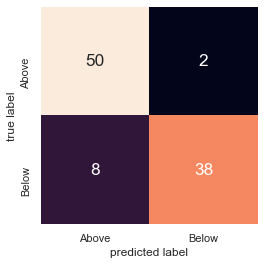

In [72]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf["classifier"].classes_, yticklabels = clf["classifier"].classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [73]:
1 - clf.score(X_test, y_test)

0.10204081632653061

When using logistic regression to predict `mpg_med` using `cylinders`, `displacement`, `horsepower`, `weight`, `year`, and `origin`, we had an overall test error of 10.2%, which is comparable to the test errors we have obtained thus far with the other methods.

In [74]:
# Exclude the origin and year columns
categorical_features = []
categorical_transformer = Pipeline([("onehot", OneHotEncoder(drop = "first"))])
numerical_features = ["cylinders", "displacement", "horsepower", "weight"]
preprocessor = ColumnTransformer([("cat", categorical_transformer, categorical_features),
                                 ("num", "passthrough", numerical_features)])
clf = Pipeline([("preprocessor", preprocessor), 
                ("classifier", LogisticRegression(penalty = "none", solver = "lbfgs", max_iter = 500))])

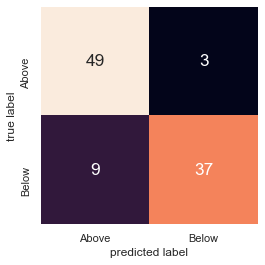

In [75]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf["classifier"].classes_, yticklabels = clf["classifier"].classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [76]:
1 - clf.score(X_test, y_test)

0.12244897959183676

If we exclude the origin and year variables, our overall test error increases very slightly, with two additional mis-classified predictions, to 12.24%.

### (f) Perform KNN with several values of *K* on the training data in order to predict `mpg_med` using the variables that seemed most associated with `mpg_med` in (b). What is the test error of the model obtained? Which value of *K* seems to perform the best on this data set?

I will try out  *k*=1,3,5,…,19  when using  *k*-nearest neighbors. As I did in the previous parts, I will first use `cylinders`, `displacement`, `horsepower`, `weight`, and `year` as the predictors. I will, however, exclude `origin` as it is a qualitative variable. I could convert it back to a numerical encoding, but then I would need to be careful to make sure each value is equidistant from the others. I also need to be careful of the different scales used to measure the various predictors, since variables such as `weight` are on the order of thousands of pounds while `displacement` is on the order of tens or hundreds of cubic inches. In order to put all of the quantitative variables on a comparable scale, I will standardize them so that all of them have mean zero and standard deviation one. As mentioned already in part (d), I will perform the standardization using `StandardScaler` as part of a pipeline.

In [77]:
numerical_features = ["cylinders", "displacement", "horsepower", "weight", "year"]
numerical_transformer = Pipeline([("standardize", StandardScaler())])
preprocessor = ColumnTransformer([("num", numerical_transformer, numerical_features)])

np.random.seed(312)
k_vals = list(range(1, 21, 2))
knn_errors = {}
confusion_matrices = {}
for k in k_vals:
    clf = Pipeline([("preprocessor", preprocessor), ("classifier", KNeighborsClassifier(n_neighbors = k))])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    confusion_matrices[k] = confusion_matrix(y_test, y_pred)
    knn_errors[k] = 1 - clf.score(X_test, y_test)
pd.Series(knn_errors)

1     0.081633
3     0.081633
5     0.081633
7     0.091837
9     0.091837
11    0.102041
13    0.081633
15    0.081633
17    0.081633
19    0.081633
dtype: float64

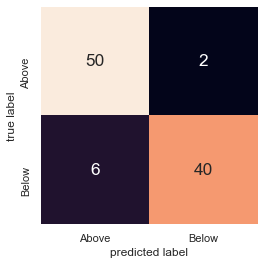

In [78]:
mat = confusion_matrices[pd.Series(knn_errors).idxmin()]
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf["classifier"].classes_, yticklabels = clf["classifier"].classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

Here we see that  *k*=1  has the lowest test error, with a value of 8.16%, though  *k*=3,5,13,15,17,19  all had the same test error value as well. Inspecting the confusion matrix for  k=1 , which I stored in the dictionary confusion_matrices, we also observe that most of the errors were false positives -- that is cars the model classified as having above-median fuel efficiency which actually were in the below-median group.

Next, I will exclude the `year` variable as I did in the previous parts to see how the test errors change.

In [79]:
numerical_features = ["cylinders", "displacement", "horsepower", "weight"]
numerical_transformer = Pipeline([("standardize", StandardScaler())])
preprocessor = ColumnTransformer([("num", numerical_transformer, numerical_features)])

np.random.seed(312)
k_vals = list(range(1, 21, 2))
knn_errors = {}
confusion_matrices = {}
for k in k_vals:
    clf = Pipeline([("preprocessor", preprocessor), ("classifier", KNeighborsClassifier(n_neighbors = k))])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    confusion_matrices[k] = confusion_matrix(y_test, y_pred)
    knn_errors[k] = 1 - clf.score(X_test, y_test)
pd.Series(knn_errors)

1     0.112245
3     0.102041
5     0.112245
7     0.102041
9     0.091837
11    0.091837
13    0.091837
15    0.091837
17    0.091837
19    0.091837
dtype: float64

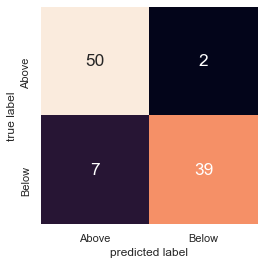

In [80]:
mat = confusion_matrices[pd.Series(knn_errors).idxmin()]
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf["classifier"].classes_, yticklabels = clf["classifier"].classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

When I excluded the `year` variable, the model generally performed a little worse, especially for lower values of  *k* . In this case, the lowest test error was with  *k*=9 , where one additional false positive brought the error up to 9.18%.

In conclusion, using  *k*-nearest neighbors with  *k*=1  and `cylinders`, `displacement`, `horsepower`, `weight`, and `year` as the predictors provided the lowest overall error on our held-out test set. We should be careful and gather more evidence by using cross-validation in order to better evaluate this model's accuracy.

***

# Question 3

### Using the `Boston` data set, fit classification models in order to predict whether a given suburb has a crime rate above or below the median. Explore logistic regression, LDA, and KNN models using various subsets of the predictors. Describe your findings.

In [81]:
boston_filepath = "https://raw.githubusercontent.com/namiyousef/ai_hack_2021/main/data/Boston_Housing_Market_Challenge/boston_fixed.csv"
index_cols = ["TOWN", "TRACT"]
data_cols = ["TOWN", "TRACT", "CMEDV", "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX",
            "PTRATIO", "B", "LSTAT"]
boston = pd.read_csv(boston_filepath, index_col = index_cols, usecols = data_cols)
boston.head()

CMEDV     CRIM   ZN  INDUS  CHAS   NOX     RM   AGE     DIS  \
TOWN      TRACT                                                                
Arlington 3567    29.9  0.06642  0.0   4.05     0  0.51  6.860  74.4  2.9153   
          3566    24.6  0.05425  0.0   4.05     0  0.51  6.315  73.4  3.3175   
          3565    23.2  0.07022  0.0   4.05     0  0.51  6.020  47.2  3.5549   
          3564    29.4  0.06664  0.0   4.05     0  0.51  6.546  33.1  3.1323   
          3563    22.6  0.08447  0.0   4.05     0  0.51  5.859  68.7  2.7019   

                 RAD  TAX  PTRATIO       B  LSTAT  
TOWN      TRACT                                    
Arlington 3567     5  296     16.6  391.27   6.92  
          3566     5  296     16.6  395.60   6.29  
          3565     5  296     16.6  393.23  10.11  
          3564     5  296     16.6  390.96   5.33  
          3563     5  296     16.6  393.23   9.64

To start, we create a binary variable, `crim_med`, which is "Above" if `CRIM` contains a value above the median and "Below" otherwise.

In [82]:
crim_med = (boston["CRIM"] > boston["CRIM"].median()).map({False: "Below", True: "Above"})
boston["crim_med"] = crim_med
boston.head()

CMEDV     CRIM   ZN  INDUS  CHAS   NOX     RM   AGE     DIS  \
TOWN      TRACT                                                                
Arlington 3567    29.9  0.06642  0.0   4.05     0  0.51  6.860  74.4  2.9153   
          3566    24.6  0.05425  0.0   4.05     0  0.51  6.315  73.4  3.3175   
          3565    23.2  0.07022  0.0   4.05     0  0.51  6.020  47.2  3.5549   
          3564    29.4  0.06664  0.0   4.05     0  0.51  6.546  33.1  3.1323   
          3563    22.6  0.08447  0.0   4.05     0  0.51  5.859  68.7  2.7019   

                 RAD  TAX  PTRATIO       B  LSTAT crim_med  
TOWN      TRACT                                             
Arlington 3567     5  296     16.6  391.27   6.92    Below  
          3566     5  296     16.6  395.60   6.29    Below  
          3565     5  296     16.6  393.23  10.11    Below  
          3564     5  296     16.6  390.96   5.33    Below  
          3563     5  296     16.6  393.23   9.64    Below

Next we explore the data both numerically, by looking at the matrix of correlations, and graphically, by looking at boxplots to investigate the association between `crim_med` and the other features. First, we look at the matrix of correlations.

In [83]:
boston.corr()["CRIM"]

CMEDV     -0.389582
CRIM       1.000000
ZN        -0.200469
INDUS      0.406583
CHAS      -0.055892
NOX        0.420972
RM        -0.219247
AGE        0.352734
DIS       -0.379670
RAD        0.625505
TAX        0.582764
PTRATIO    0.289946
B         -0.385064
LSTAT      0.455621
Name: CRIM, dtype: float64

We see that there are some moderate to moderately strong correlations between crime rate and the other variables. The most correlated variables are `RAD` (correlation of 0.626), a measure of accessibility to radial highways, and `TAX` (correlation of 0.583), the property tax rate in USD per \\$10,000. In fact, all of the variables aside from `CHAS`, an indicator variable with value 1 if a town borders the Charles River, have correlation values with a magnitude of at least 0.2. In addition, as we saw in Applied Exercise 8 from Chapter 3, every predictor aside from `CHAS` had a statistically significant association with `CRIM` when we performed univariate linear regressions. While we should first explore the data graphically, there are two possible subsets of predictors that immeidately jump out as candidates for use in producing models to predict whether or not a given suburb has a per capita crime rate above the median. First would be to use all of the predictors aside from `CHAS` and second would be to use the predictors with a correlation magnitude of at least 0.3 (`CMEDV`, `INDUS`, `NOX`, `AGE`, `DIS`, `RAD`, `TAX`, `B`, and `LSTAT`). We will make models using both subsets of predictors to compare the predictive strength of the various models. Before making further choices regarding which predictors to use when fitting models, we will look at boxplots to explore the data graphically. We start with boxplots of each predictor, aside from `CHAS`, comparing the suburbs with above-median crime rate and those with below-median crime rate.

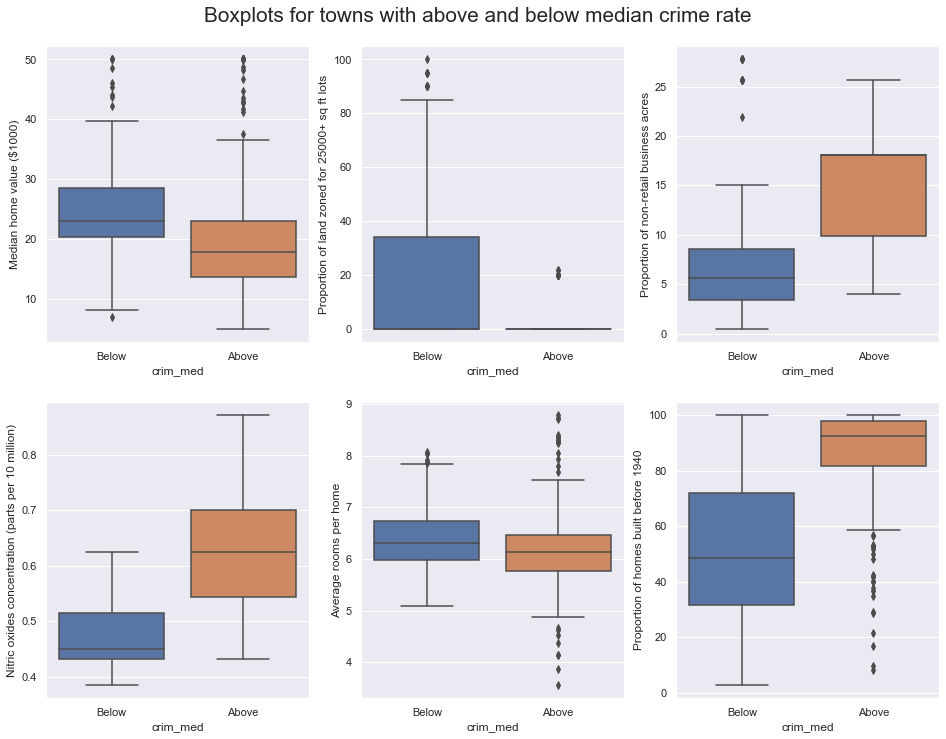

In [84]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (16, 12))
sns.boxplot(x = "crim_med", y = "CMEDV", data = boston, ax = axes[0, 0])
axes[0, 0].set_ylabel("Median home value ($1000)")
sns.boxplot(x = "crim_med", y = "ZN", data = boston, ax = axes[0, 1])
axes[0, 1].set_ylabel("Proportion of land zoned for 25000+ sq ft lots")
sns.boxplot(x = "crim_med", y = "INDUS", data = boston, ax = axes[0, 2])
axes[0, 2].set_ylabel("Proportion of non-retail business acres")
sns.boxplot(x = "crim_med", y = "NOX", data = boston, ax = axes[1, 0])
axes[1, 0].set_ylabel("Nitric oxides concentration (parts per 10 million)")
sns.boxplot(x = "crim_med", y = "RM", data = boston, ax = axes[1, 1])
axes[1, 1].set_ylabel("Average rooms per home")
sns.boxplot(x = "crim_med", y = "AGE", data = boston, ax = axes[1, 2])
axes[1, 2].set_ylabel("Proportion of homes built before 1940")
fig.suptitle("Boxplots for towns with above and below median crime rate", size = "xx-large", y = 0.925);

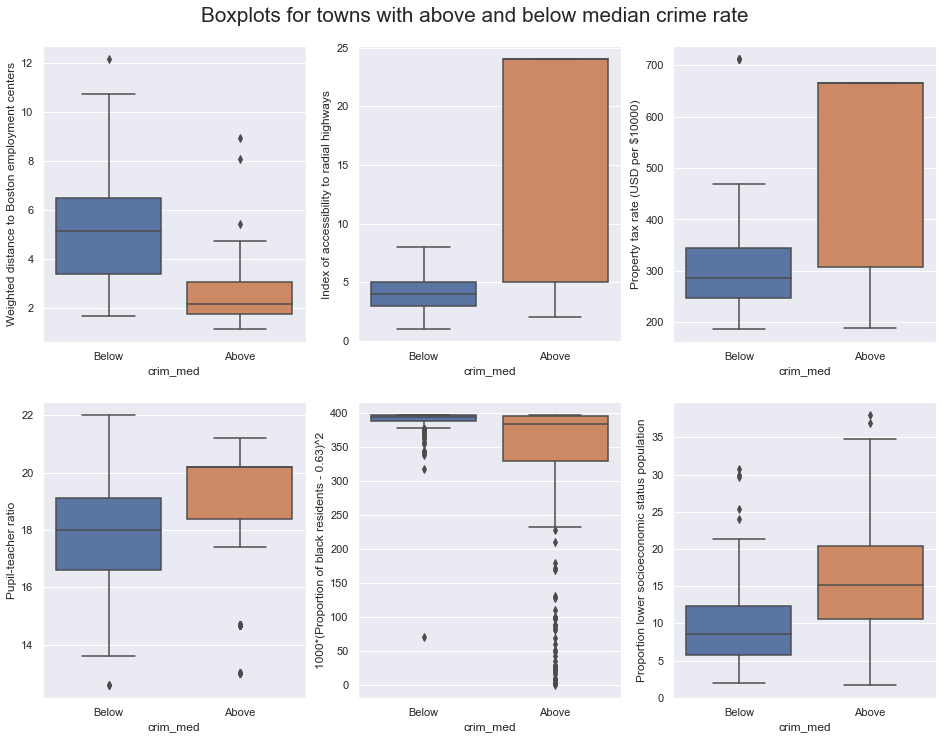

In [85]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (16, 12))
sns.boxplot(x = "crim_med", y = "DIS", data = boston, ax = axes[0, 0])
axes[0, 0].set_ylabel("Weighted distance to Boston employment centers")
sns.boxplot(x = "crim_med", y = "RAD", data = boston, ax = axes[0, 1])
axes[0, 1].set_ylabel("Index of accessibility to radial highways")
sns.boxplot(x = "crim_med", y = "TAX", data = boston, ax = axes[0, 2])
axes[0, 2].set_ylabel("Property tax rate (USD per $10000)")
sns.boxplot(x = "crim_med", y = "PTRATIO", data = boston, ax = axes[1, 0])
axes[1, 0].set_ylabel("Pupil-teacher ratio")
sns.boxplot(x = "crim_med", y = "B", data = boston, ax = axes[1, 1])
axes[1, 1].set_ylabel("1000*(Proportion of black residents - 0.63)^2")
sns.boxplot(x = "crim_med", y = "LSTAT", data = boston, ax = axes[1, 2])
axes[1, 2].set_ylabel("Proportion lower socioeconomic status population")
fig.suptitle("Boxplots for towns with above and below median crime rate", size = "xx-large", y = 0.925);

The twelve boxplots we produced provide further evidence to suggest that the predictors which are likely to be most useful in predicting `crim_med` are those having a correlation magnitude of at least 0.3 with `CRIM` (`CMEDV`, `INDUS`, `NOX`, `AGE`, `DIS`, `RAD`, `TAX`, `B`, and `LSTAT`). Those are the variables which show the most separation in distributions between the suburbs with above-median crime rates and those with below-median crime rates. In particular, for all of those variables except `CMEDV`, it appears that the medians for the suburbs with above-median crime rates are well clear of the upper or lower quartile (depending on the particular variable) of the values for suburbs with below-median crime rates. Therefore, we will proceed and produce models using two different subsets of predictors: all of them aside from CHAS, and only the ones which are at least moderately correlated with `CRIM` (`CMEDV`, `INDUS`, `NOX`, `AGE`, `DIS`, `RAD`, `TAX`, `B`, and `LSTAT`).

Before training any models, we split our data in to a training set and a test set using the 75%-25% split.

In [86]:
X_train, X_test, y_train, y_test = train_test_split(boston, boston["crim_med"], test_size = 0.25, random_state = 312)

We also make two arrays of columns to help with selecting the particular subsets of columns we wish to use: all of the predictors aside from `CHAS`, and those which are at least moderately correlated with `CRIM` (absolute value of correlation at least 0.3).

In [87]:
not_chas = boston.columns.drop(["CHAS", "CRIM", "crim_med"])
moderate_corr = boston.corr().loc[(boston.corr()["CRIM"].abs() > 0.3), "CRIM"].index.drop("CRIM")

Now that we have split the data in to a training set and a test set, we fit classification models to predict whether or not a given suburb has an above-median crime rate. Note that for this exercise we will stick with the default prediction threshold of 50% for convenience. If we were trying to make predictions for an application, then we should consider other prediction thresholds depending on our tolerance for false positives versus false negatives. Here we use the convention that an above-median crime rate is the positive category and below-median the negative category. For each model, we will first use all of the predictors before using the ones which are at least moderately correlated with `CRIM`. The first classification model we use is logistic regression.

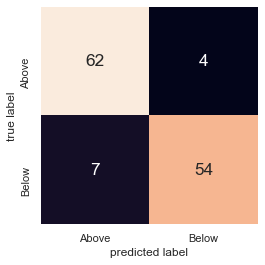

In [88]:
clf = LogisticRegression(penalty = "none", solver = "lbfgs", max_iter = 10000)
clf.fit(X_train[not_chas], y_train)
y_pred = clf.predict(X_test[not_chas])
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf.classes_, yticklabels = clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [89]:
1 - clf.score(X_test[not_chas], y_test)

0.08661417322834641

When using logistic regression to predict `crim_med` using all of the predictors aside from `CHAS`, we had an overall test error of 8.66%. Our positive predictive value was  $62/69≈0.898$ and our true positive rate was  $62/68≈0.939$ . So far that seems like a pretty good error rate for the first model we tried, so lets continue with the smaller subset of predictors and then move on to other models to see if we can improve the performance at all.

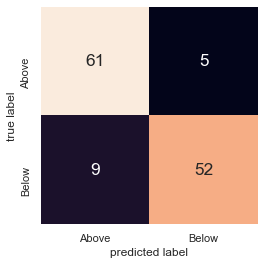

In [90]:
clf = LogisticRegression(penalty = "none", solver = "lbfgs", max_iter = 10000)
clf.fit(X_train[moderate_corr], y_train)
y_pred = clf.predict(X_test[moderate_corr])
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf.classes_, yticklabels = clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [91]:
1 - clf.score(X_test[moderate_corr], y_test)

0.11023622047244097

The logistic regression model using fewer predictors (`CMEDV`, `INDUS`, `NOX`, `AGE`, `DIS`, `RAD`, `TAX`, `B`, and `LSTAT`) performed slightly worse, with an overall test error of 11.02%. It had a positive predictive value of  $61/70≈0.871$ , which is a slight decrease from the model with more predictors. However, the true positive rate is slightly better, at  $61/66≈0.924$ . This is due to the fact that source of error for the model with fewer predictors is mis-classifying suburbs which actually have below-median crime rates as being in the above-median category. We now move on to linear discriminant analysis.

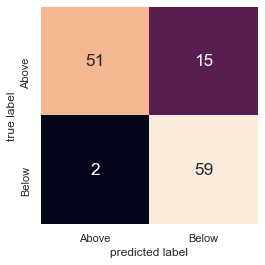

In [92]:
clf = LinearDiscriminantAnalysis()
clf.fit(X_train[not_chas], y_train)
y_pred = clf.predict(X_test[not_chas])
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf.classes_, yticklabels = clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [93]:
1 - clf.score(X_test[not_chas], y_test)

0.13385826771653542

Compared to the logistic regression model using all of the predictors aside from `CHAS`, linear discriminant analysis performed much worse, with an overal test error of 13.4%. That is almost double the overall test error from logistic regression. This performance discrepancy suggests that the assumption underlying LDA, that the observations are drawn from a Gaussian distribution where both classes share a common covariance matrix, are not met for at least some of these predictors. Here, the main source of the error comes from mis-classifying suburbs which actually have above-median crime rates as being in the below-median category.

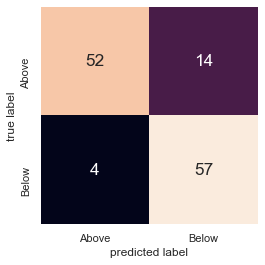

In [94]:
clf = LinearDiscriminantAnalysis()
clf.fit(X_train[moderate_corr], y_train)
y_pred = clf.predict(X_test[moderate_corr])
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf.classes_, yticklabels = clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [95]:
1 - clf.score(X_test[moderate_corr], y_test)

0.1417322834645669

Similar to the model which used all of the predictors aside from CHAS, linear discriminant analysis using fewer predictors (`CMEDV`, `INDUS`, `NOX`, `AGE`, `DIS`, `RAD`, `TAX`, `B`, and `LSTAT`) performed worse than the logistic regression model using the same predictors. It did, however, perform a bit better than the LDA model which used more predictors. So far logistic regression appears to give the best test error rate. We continue on to quadratic discriminant analysis.

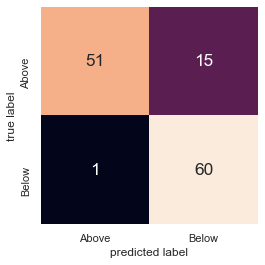

In [96]:
clf = QuadraticDiscriminantAnalysis()
clf.fit(X_train[not_chas], y_train)
y_pred = clf.predict(X_test[not_chas])
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf.classes_, yticklabels = clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [97]:
1 - clf.score(X_test[not_chas], y_test)

0.12598425196850394

Quadratic discriminant analysis with all of the predictors aside from `CHAS` had an overall test error of 12.5%, which is comparable to that of logistic regression using the predictors `CMEDV`, `INDUS`, `NOX`, `AGE`, `DIS`, `RAD`, `TAX`, `B`, and `LSTAT`. This is a solid improvement over linear discriminant analysis using the same predictors, and suggests that relaxing the assuption of a common covariance matrix for both classes to assuming each class has its own covariance matrix is a more accurate assumption about the data. One thing of note is that the QDA model has a high positive predictive value of  $51/52≈0.981$ , which is highest value out of all of the models we have seen up to this point. This model would be very good if our priority is to minimize the number of suburbs with below-median crime rates that are predicted to be in the above-median category.

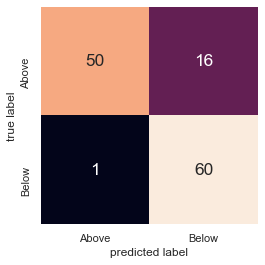

In [98]:
clf = QuadraticDiscriminantAnalysis()
clf.fit(X_train[moderate_corr], y_train)
y_pred = clf.predict(X_test[moderate_corr])
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf.classes_, yticklabels = clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [99]:
1 - clf.score(X_test[moderate_corr], y_test)

0.13385826771653542

Reducing to the smaller subset of predictors (`CMEDV`, `INDUS`, `NOX`, `AGE`, `DIS`, `RAD`, `TAX`, `B`, and `LSTAT`) resulted in a QDA model that performs slightly worse in terms of overall test error rate (13.4%) than the QDA model with more predictors. Even so, this QDA model still has a better overall test error rate than both of the LDA models.

For  *k*-nearest neighbors classification, we make sure to standardize all of the variables to have mean zero and standard deviation one by using a pipeline with the `StandardScaler` as we did in part (g) of Question 2 above.

In [100]:
np.random.seed(312)
k_vals = list(range(1, 21, 2))
knn_errors = {}
confusion_matrices = {}
for k in k_vals:
    clf = Pipeline([("standardize", StandardScaler()), ("classifier", KNeighborsClassifier(n_neighbors = k))])
    clf.fit(X_train[not_chas], y_train)
    y_pred = clf.predict(X_test[not_chas])
    confusion_matrices[k] = confusion_matrix(y_test, y_pred)
    knn_errors[k] = 1 - clf.score(X_test[not_chas], y_test)
pd.Series(knn_errors)

1     0.062992
3     0.070866
5     0.070866
7     0.062992
9     0.062992
11    0.086614
13    0.094488
15    0.110236
17    0.141732
19    0.173228
dtype: float64

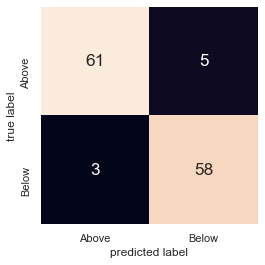

In [101]:
mat = confusion_matrices[1]
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf.classes_, yticklabels = clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

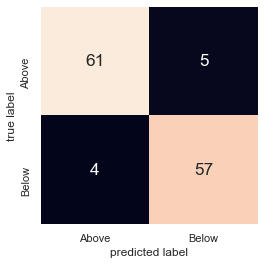

In [102]:
mat = confusion_matrices[3]
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf.classes_, yticklabels = clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [103]:
61/66

0.9242424242424242

We see that when using all of the predictors aside from `CHAS`, the values of  *k*  with the lowest overall test error for  *k*-nearest neighbors classification are  *k*=1  and  *k*=3 , with an overal test error of 6.3%. This is two fewer mis-classified test observations compared to logistic regression using the same predictors and provides the best overall test error rate of the model/predictor combinations we have investigated thus far. Looking at the confusion matrix, we see that KNN with  *k*=3  has the best positive predictive value out of all of the classification models,  $61/65≈0.938$ , and compared to logistic regression using the same predictors, this model has the same true positive rate ( $61/66≈0.924$  vs $0.924$) as well.

In [104]:
np.random.seed(312)
k_vals = list(range(1, 21, 2))
knn_errors = {}
confusion_matrices = {}
for k in k_vals:
    clf = Pipeline([("standardize", StandardScaler()), ("classifier", KNeighborsClassifier(n_neighbors = k))])
    clf.fit(X_train[moderate_corr], y_train)
    y_pred = clf.predict(X_test[moderate_corr])
    confusion_matrices[k] = confusion_matrix(y_test, y_pred)
    knn_errors[k] = 1 - clf.score(X_test[moderate_corr], y_test)
pd.Series(knn_errors)

1     0.078740
3     0.086614
5     0.070866
7     0.086614
9     0.102362
11    0.118110
13    0.125984
15    0.125984
17    0.133858
19    0.133858
dtype: float64

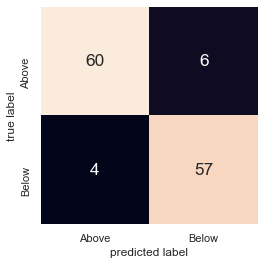

In [105]:
mat = confusion_matrices[1]
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf.classes_, yticklabels = clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

Reducing to the smaller subset of predictors (`CMEDV`, `INDUS`, `NOX`, `AGE`, `DIS`, `RAD`, `TAX`, `B`, and `LSTAT`), we see that again the value of  *k*  with the lowest overall test error rate is  *k*=1 . In this case, however, KNN with  *k*=1  and this subset of predictors performed slightly worse than the previous KNN classifier which used more predictors. Looking at the confusion matrix compared to  *k*=3  above, we see that all of the additional errors come from false positives.

While we would need more precisely determine the metrics by which we would choose our preferred model and then perform further testing, such as cross validation, to more confidently choose a model, it seems as if there are two likely frontrunners to choose: logistic regression using all of the predictors aside from `CHAS`, and  *k*-nearest neighbors using  *k*=3  the same set of predictors. The strength of the logistic regression model lies in relative simplicity and interpretability compared to KNN, as well as the fact that it had the second lowest overall test error out of the models we explored. The KNN classifier had slightly lower overall test error, but had a much better positive predictive value than logistic regression, at least when logistic regression used a prediction threshold of 0.5. One graphic we could use to better compare the performance of these two models would be to produce ROC curves for each model and compare the two area-under-curve values.

***

## Question 4

### We have seen that we can fit an SVM with a non-linear kernel in order to perform classification using a non-linear decision boundary. We will now see that we can also obtain a non-linear decision boundary by performing logistic regression using non-linear transformations of the features.

### (a) Generate a data set with *n* = 500 and *p* = 2, such that the observations belong to two classes with a quadratic decision boundary between them. For instance, you can do this as follows:

```
np.random.seed(1)
n = 500
p = 2

x1 = np.random.uniform(0, 1, n) - 0.5
x2 = np.random.uniform(0, 1, n) - 0.5
y  = 1*(x1**2-x2**2 > 0)
df = pd.DataFrame({'x1':x1, 'x2':x2, 'y':y})
```

In [106]:
np.random.seed(1)
n = 500
p = 2

x1 = np.random.uniform(0, 1, n) - 0.5
x2 = np.random.uniform(0, 1, n) - 0.5
y  = 1*(x1**2-x2**2 > 0)
df = pd.DataFrame({'x1':x1, 'x2':x2, 'y':y})
df.head()

,x1,x2,y
0,-0.082978,-0.412518,0
1,0.220324,-0.272690,0
2,-0.499886,-0.185623,1
3,-0.197667,-0.325234,0
4,-0.353244,0.107094,1


### (b) Plot the observations, colored according to their class labels. Your plot should display $X_1$ on the $x$-axis, and $X_2$ on the $y$-axis.

Text(0, 0.5, 'X2')

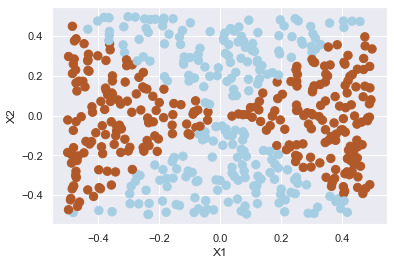

In [107]:
plt.scatter(x1, x2, s=70, c=y, cmap=mpl.cm.Paired)
plt.xlabel('X1')
plt.ylabel('X2')

### (c) Fit a logistic regression model to the data, using $X_1$ and $X_2$ as predictors.

In [108]:
X=df.drop(columns=["y"])
y=df["y"]

# By default scikit-learn uses an l2 regularization penalty, which we don't want for
# vanilla logistic regression as described in the book
log_reg = LogisticRegression(penalty = "none", solver = "lbfgs")
log_reg.fit(X, y)
params = np.concatenate((log_reg.intercept_, log_reg.coef_.flatten()))
pd.DataFrame(data = {"Coef. Est.":params}, index = X.columns.insert(0, "intercept"))

,Coef. Est.
intercept,0.159565
x1,-0.091554
x2,-0.252300


### (d) Apply this model to the *training data* in order to obtain a predicted class label for each training observation. Plot the observations, colored according to the *predicted* class labels. The decision boundary should be linear.

In [109]:
log_reg_probs = log_reg.predict_proba(X)
pd.DataFrame(log_reg_probs, columns = log_reg.classes_).head(10)

,0,1
0,0.432603,0.567397
1,0.448139,0.551861
2,0.437291,0.562709
3,0.435433,0.564567
4,0.458872,0.541128
5,0.445544,0.554456
6,0.472908,0.527092
7,0.437049,0.562951
8,0.470513,0.529487
9,0.444845,0.555155


In [110]:
log_reg_pred = log_reg.predict(X)
logit_res=pd.DataFrame(np.hstack((log_reg_probs, log_reg_pred.reshape(-1,1))), 
             columns = np.concatenate((log_reg.classes_, ["Prediction"])))
logit_res.head(10)

,0,1,Prediction
0,0.432603,0.567397,1.0
1,0.448139,0.551861,1.0
2,0.437291,0.562709,1.0
3,0.435433,0.564567,1.0
4,0.458872,0.541128,1.0
5,0.445544,0.554456,1.0
6,0.472908,0.527092,1.0
7,0.437049,0.562951,1.0
8,0.470513,0.529487,1.0
9,0.444845,0.555155,1.0


Training accuracy: 0.542


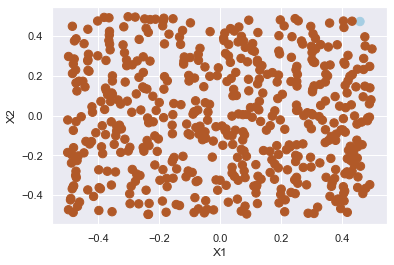

In [111]:
plt.scatter(x1, x2, s=70, c=logit_res["Prediction"], cmap=mpl.cm.Paired)
plt.xlabel('X1')
plt.ylabel('X2')

print(f'Training accuracy: {log_reg.score(X, y)}')

### (e) Now fit a logistic regression model to the data using non-linear functions of $X_1$ and $X_2$ as predictors (e.g. $X_{1}^2$, $X_1$x$X_2$, log($X_2$), and so forth).

In [112]:
new_X=X
new_X["x1_sq"]=np.power(X["x1"], 2)
new_X["x2_sq"]=np.power(X["x2"], 2)
new_X["x1x2"]=X["x1"]*X["x2"]
#new_X["log_x1"]=np.log(X["x1"])
#new_X["log_x2"]=np.log(X["x2"])
new_X.head()

,x1,x2,x1_sq,x2_sq,x1x2
0,-0.082978,-0.412518,0.006885,0.170171,0.034230
1,0.220324,-0.272690,0.048543,0.074360,-0.060080
2,-0.499886,-0.185623,0.249886,0.034456,0.092790
3,-0.197667,-0.325234,0.039072,0.105777,0.064288
4,-0.353244,0.107094,0.124781,0.011469,-0.037830


Can't take the log of negative numbers, so i'll just stick with the power transforms

In [113]:
# fit the logit model
power_logit=LogisticRegression().fit(new_X, y)
params = np.concatenate((power_logit.intercept_, power_logit.coef_.flatten()))
pd.DataFrame(data = {"Coef. Est.":params}, index = new_X.columns.insert(0, "intercept"))

,Coef. Est.
intercept,0.083531
x1,-0.124443
x2,-0.237175
x1_sq,6.587327
x2_sq,-6.213156
x1x2,0.187837


### (f) Apply this model to the *training data* in order to obtain a predicted class label for each training observation. Plot the observations, colored according to the *predicted class* labels. The decision boundary should be obviously non-linear. If it is not, then repeat (a)-(e) until you come up with an example in which the predicted class labels are obviously non-linear.

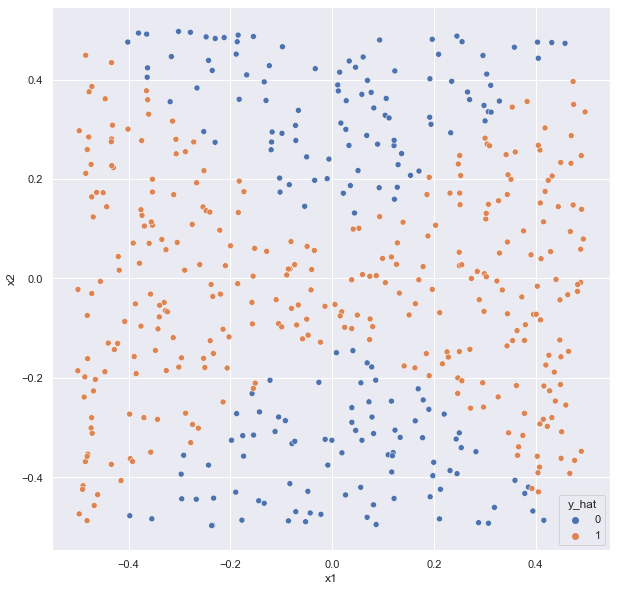

Training accuracy: 0.922


In [114]:
# make prediction
power_logit_pred = power_logit.predict(new_X)

# plot it
plot_power_logit = pd.DataFrame({'x1': X["x1"], 'x2':X["x2"], 'y_hat':power_logit_pred})
plt.figure(figsize=(10, 10))
sns.scatterplot(x='x1', y='x2', hue='y_hat', data=plot_power_logit)
plt.show();

print(f'Training accuracy: {power_logit.score(new_X, y)}')

### (g) Fit a support vector classifier to the data with $X_1$ and $X_2$ as predictors. Obtain a class prediction for each training observation. Plot the observations, colored according to the predicted class labels.

D:\anaconda3\lib\site-packages\mlxtend\plotting\decision_regions.py:243: UserWarning: No contour levels were found within the data range.
  ax.contour(xx, yy, Z, cset.levels,


Training accuracy: 0.54


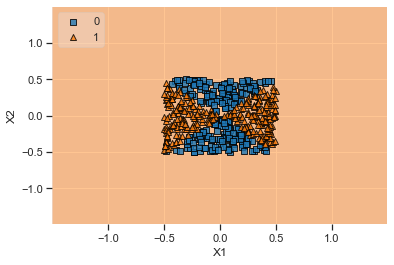

In [115]:
import patsy as pt
from sklearn import svm
f = 'y ~ x1 + x2 - 1'
y, X = pt.dmatrices(f, df)
y = np.ravel(y)

model = svm.SVC(kernel='linear', gamma=1, C=1, random_state=0, probability=True).fit(X, y)

plot_decision_regions(X,y.astype(np.int_),model, legend=2)
plt.xlabel('X1')
plt.ylabel('X2')

print(f'Training accuracy: {model.score(X, y)}')

`plot_decision_regions` not working. Try something else.

In [116]:
def plot_clf(model, df, grid_range, show_contours=False, show_support_vectors=False):
    # Decision boundary plot
    
    # Get grid of values in given range
    x1 = grid_range
    x2 = grid_range
    xx1, xx2 = np.meshgrid(x1, x2, sparse=False)
    Xgrid = np.stack((xx1.flatten(), xx2.flatten())).T
    
    # Get decision boundary values for plot grid
    decision_boundary      = model.predict(Xgrid)
    decision_boundary_grid = decision_boundary.reshape(len(x2), len(x1))
    
    # Get decision function values for plot grid
    decision_function      = model.decision_function(Xgrid)
    decision_function_grid = decision_function.reshape(len(x2), len(x1))
    
    fig = plt.figure(figsize=(10, 10))
    if show_contours:
        plt.contourf(x1, x2, decision_function_grid);
    plt.contour(x1, x2, decision_boundary_grid);
    
    sns.scatterplot(x='x1', y='x2', hue='y', data=df)
    if show_support_vectors:
        sns.scatterplot(x=model.support_vectors_[:,0], y=model.support_vectors_[:,1], color='red', marker='+', s=500)
    plt.show();

<ipython-input-116-bc67cecb824c>:21: UserWarning: No contour levels were found within the data range.
  plt.contour(x1, x2, decision_boundary_grid);


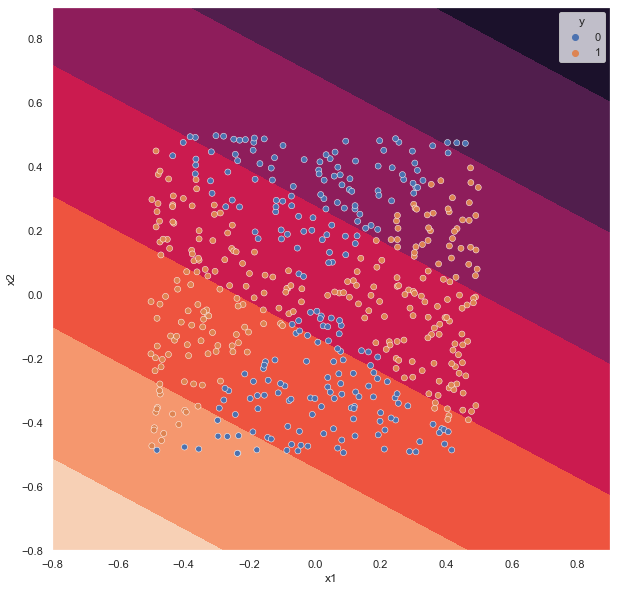

In [117]:
plot_clf(model, df, np.arange(-.8, .9, .005), show_contours=True)

### (h) Fit a SVM using a non-linear kernel to the data. Obtain a class prediction for each training observation. Plot the observations, colored according to the *predicted class labels*.

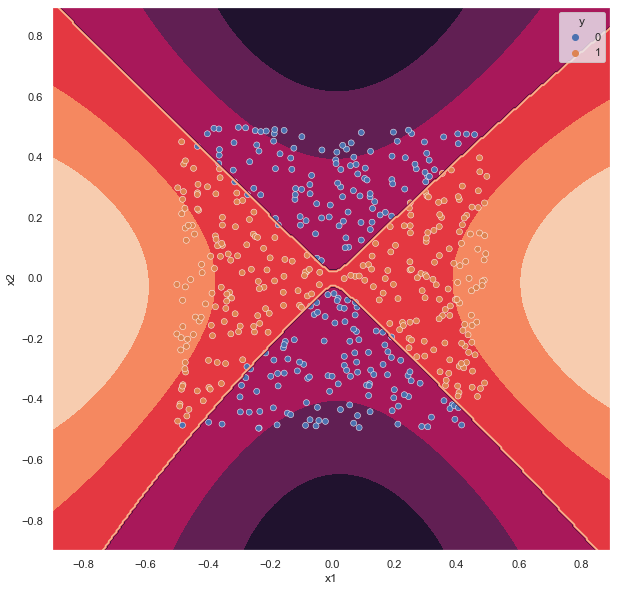

Training accuracy: 0.982


In [118]:
f = 'y ~ x1 + x2 - 1'
y, X = pt.dmatrices(f, df)
y = np.ravel(y)

model = svm.SVC(kernel='rbf', gamma=1, C=1, random_state=0, probability=True).fit(X, y)

plot_clf(model, df, np.arange(-.9, .9, .005), show_contours=True)

print(f'Training accuracy: {model.score(X, y)}')

### (i) Comment on your results.

Polynomial logistic regression and SVM with radial kernel achieve similar fits to the data. The SVM performs best on the training set with an accuracy of 98.2% compared to 92.2% from logistic regression. Of course, splitting the data into training and test sets would provide a more accurate assessment of fit. These training rates are likely overstated.

The linear support vector classifier achieves poor results because the seperation between classes is far from linear.

***

## Question 5 
### In this problem, you will use support vector approaches in order to predict whether a given car gets high or low gas mileage based on the `Auto` data set.

### (a) Create a binary variable that takes on a 1 for cars with gas mileage above the median, and a 0 for cars with gas mileage below the median.

In [119]:
auto_df = pd.read_csv('Auto.csv')

# Remove observations with missing values
auto_df = auto_df.drop(auto_df[auto_df.values == '?'].index)
#auto_df = auto_df.reset_index()

# convert quantitive values to floats
#quants = ['cylinders', 'horsepower', 'weight', 'year']
quants = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin']
auto_df[quants] = auto_df[quants].astype(np.float64)

auto_df['mpg_above_median'] = (auto_df['mpg'] > auto_df['mpg'].median()) *1.
auto_df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg_above_median
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0,chevrolet chevelle malibu,0.0
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0,buick skylark 320,0.0
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.0,plymouth satellite,0.0
3,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1.0,amc rebel sst,0.0
4,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1.0,ford torino,0.0


### (b) Fit a support vector classifier to the data with various values of cost, in order to predict whether a car gets high or low gas mileage. Report the cross-validation errors associated with different values of this parameter. Comment on your results.

In [120]:
from sklearn import preprocessing
f = 'mpg_above_median ~ cylinders + displacement + horsepower + weight + acceleration + year + C(origin)'
y, X = pt.dmatrices(f, auto_df)

# Scale data
X = preprocessing.scale(X)
y = np.ravel(y)

In [121]:
costs = np.logspace(-5, 2, 20)
scores = []
for i in costs:
    # Get cv score 
    model = svm.SVC(kernel='linear', C=i, random_state=0)
    score = np.mean(cross_val_score(model, preprocessing.scale(X), y, cv=5))
    scores += [[i, score]]
    #print(f'progress: {list(costs).index(i)} of {len(costs)}')

columns=['Cost', 'CV_accuracy']
results_df = pd.DataFrame(data=np.asarray(scores), columns=columns)

display(results_df)

,Cost,CV_accuracy
0,0.000010,0.630802
1,0.000023,0.630802
2,0.000055,0.630802
3,0.000127,0.630802
4,0.000298,0.681435
5,0.000695,0.818306
6,0.001624,0.877215
7,0.003793,0.882376
8,0.008859,0.902889
9,0.020691,0.895326


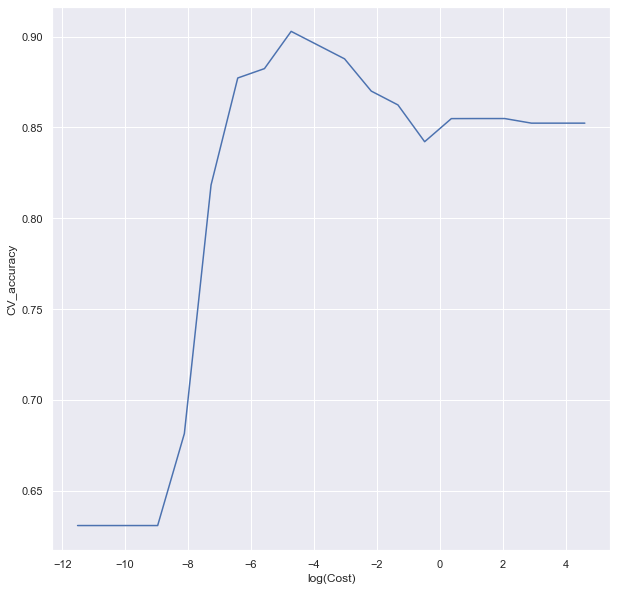

In [122]:
results_df['log(Cost)'] = np.log(results_df['Cost'])
plt.figure(figsize=(10,10))
sns.lineplot(x='log(Cost)', y='CV_accuracy', data=results_df);

### (c) Now repeat (b), this time using SVMs with radial and polynomial basis kernels, with different values of gamma and degree and cost. Comment on your results.

In [123]:
# Grid search for best classifier
# https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#sphx-glr-auto-examples-svm-plot-rbf-parameters-py
# ----------------------------------------------------------------

C_range     = np.logspace(-5, 3, 10)
gamma_range = np.logspace(-5, 3, 10)
kernels     = ['rbf', 'poly']
degrees     = [3, 5, 7, 9]     # Using only odd values, because I noticed earlier evens are slow!
param_grid  = dict(gamma=gamma_range, C=C_range, kernel=kernels, degree=degrees)
rbf_grid = GridSearchCV(svm.SVC(cache_size=2000), param_grid=param_grid, cv=5, 
                        scoring='accuracy', return_train_score=True)
rbf_grid.fit(X, y)

GridSearchCV(cv=5, estimator=SVC(cache_size=2000),
             param_grid={'C': array([1.00000000e-05, 7.74263683e-05, 5.99484250e-04, 4.64158883e-03,
       3.59381366e-02, 2.78255940e-01, 2.15443469e+00, 1.66810054e+01,
       1.29154967e+02, 1.00000000e+03]),
                         'degree': [3, 5, 7, 9],
                         'gamma': array([1.00000000e-05, 7.74263683e-05, 5.99484250e-04, 4.64158883e-03,
       3.59381366e-02, 2.78255940e-01, 2.15443469e+00, 1.66810054e+01,
       1.29154967e+02, 1.00000000e+03]),
                         'kernel': ['rbf', 'poly']},
             return_train_score=True, scoring='accuracy')

In [124]:
rbf_grid.best_params_

{'C': 2.154434690031882,
 'degree': 3,
 'gamma': 0.004641588833612777,
 'kernel': 'rbf'}

In [125]:
pd.DataFrame(rbf_grid.cv_results_).sort_values('rank_test_score', ascending=True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_degree,param_gamma,param_kernel,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
526,0.002009,0.000016,0.000797,0.000398,2.15443,7,0.00464159,rbf,"{'C': 2.154434690031882, 'degree': 7, 'gamma':...",0.936709,...,0.902921,0.027958,1,0.916933,0.907348,0.923567,0.910828,0.917197,0.915175,0.005617
486,0.002592,0.000798,0.000798,0.000399,2.15443,3,0.00464159,rbf,"{'C': 2.154434690031882, 'degree': 3, 'gamma':...",0.936709,...,0.902921,0.027958,1,0.916933,0.907348,0.923567,0.910828,0.917197,0.915175,0.005617
546,0.002193,0.000400,0.000797,0.000399,2.15443,9,0.00464159,rbf,"{'C': 2.154434690031882, 'degree': 9, 'gamma':...",0.936709,...,0.902921,0.027958,1,0.916933,0.907348,0.923567,0.910828,0.917197,0.915175,0.005617
506,0.001802,0.000738,0.000592,0.000483,2.15443,5,0.00464159,rbf,"{'C': 2.154434690031882, 'degree': 5, 'gamma':...",0.936709,...,0.902921,0.027958,1,0.916933,0.907348,0.923567,0.910828,0.917197,0.915175,0.005617
390,0.003973,0.000642,0.001195,0.000398,0.0359381,9,0.278256,rbf,"{'C': 0.03593813663804626, 'degree': 9, 'gamma...",0.949367,...,0.900325,0.033167,5,0.900958,0.907348,0.917197,0.910828,0.914013,0.910069,0.005610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,0.007575,0.000484,0.002000,0.000014,7.74264e-05,7,1000,rbf,"{'C': 7.742636826811278e-05, 'degree': 7, 'gam...",0.493671,...,0.497468,0.003101,777,0.501597,0.501597,1.000000,1.000000,1.000000,0.800639,0.244166
78,0.008179,0.000398,0.001993,0.000003,1e-05,9,1000,rbf,"{'C': 1e-05, 'degree': 9, 'gamma': 1000.0, 'ke...",0.493671,...,0.497468,0.003101,777,0.501597,0.501597,1.000000,1.000000,1.000000,0.800639,0.244166
278,0.008178,0.000399,0.002209,0.000416,0.00464159,5,1000,rbf,"{'C': 0.004641588833612777, 'degree': 5, 'gamm...",0.493671,...,0.497468,0.003101,777,0.501597,0.501597,1.000000,1.000000,1.000000,0.800639,0.244166
158,0.008377,0.000489,0.002194,0.000399,7.74264e-05,9,1000,rbf,"{'C': 7.742636826811278e-05, 'degree': 9, 'gam...",0.493671,...,0.497468,0.003101,777,0.501597,0.501597,1.000000,1.000000,1.000000,0.800639,0.244166


The above table lists the models tested by grid search, ranked by cross-validation test scores.

A radial kernel performs best, with a mean CV accuracy of 0.902921.

### (d) Make some plots to back up your assertions in (b) and (c).

I think the error estimations are enough. Make a bar chart comparing the best error of the linear svm against the radial svm, but why?

***

## Question 6
### This problem involves the `OJ` data set which is part of the ISLR package.

In [126]:
oj_df = pd.read_csv('OJ.csv')
oj_df.head()

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
1,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
2,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
3,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
4,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0


### (a) Create a training set containing a random sample of 800 observations, and a test set containing the remaining observations.

In [127]:
preds = "+".join(oj_df.columns.drop("Purchase"))
f = f'Purchase ~ {preds}'
y, X = pt.dmatrices(f, oj_df)
y = y[:, 0]

# scale data
X = preprocessing.scale(X)

# Split training test sets
test_size = len(y)-800
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)

### (b) Fit a support vector classifier to the training data using `cost=0.01`, with Purchase as the response and the other variables as predictors. Use the `summary()` function to produce summary statistics, and describe the results obtained.

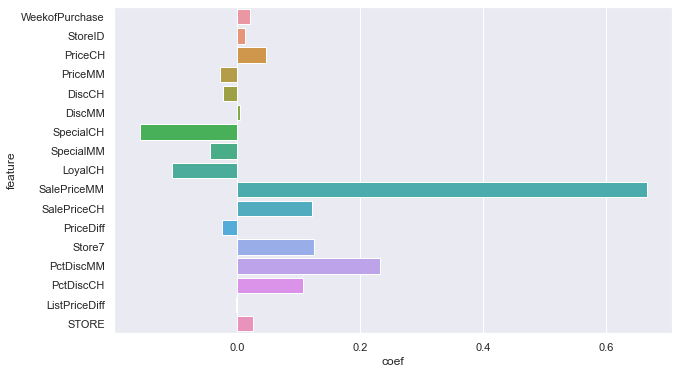

In [128]:
model = svm.LinearSVC(C=0.1, random_state=0).fit(X_train, y_train)

df = pd.DataFrame({'feature': oj_df.columns.drop('Purchase'),
              'coef': np.ravel(model.coef_)[1:]})
plt.figure(figsize=(10,6))
sns.barplot(x='coef', y='feature', data=df);

### (c) What are the training and test error rates?

In [129]:
accuracy_train = model.score(X_train, y_train)
accuracy_test  = model.score(X_test, y_test)
print(f'train accuracy: {accuracy_train:.3f}')
print(f'test accuracy : {accuracy_test:.3f}')

train accuracy: 0.840
test accuracy : 0.830


### (d) Use the `GridSearchCV()` function to select an optimal cost. Consider values in the range 0.01 to 10.

In [130]:
C_range     = np.logspace(-2, 1, 10)
param_grid  = dict(C=C_range)
model_grid  = GridSearchCV(svm.LinearSVC(), param_grid=param_grid, cv=5, 
                           scoring='accuracy', return_train_score=True)
model_grid.fit(X, y)

D:\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
D:\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


GridSearchCV(cv=5, estimator=LinearSVC(),
             param_grid={'C': array([ 0.01      ,  0.02154435,  0.04641589,  0.1       ,  0.21544347,
        0.46415888,  1.        ,  2.15443469,  4.64158883, 10.        ])},
             return_train_score=True, scoring='accuracy')

### (e) Compute the training and test error rates using this new value for `cost`.

In [131]:
accuracy_train = model_grid.score(X_train, y_train)
accuracy_test  = model_grid.score(X_test, y_test)
print(f'train accuracy: {accuracy_train:.3f}')
print(f'test accuracy : {accuracy_test:.3f}')

train accuracy: 0.831
test accuracy : 0.841


### (f) Repeat parts (b) through (e) using a support vector machine with a radial kernel. Use the default value for `gamma`.

In [132]:
C_range     = np.logspace(-2, 1, 10)
param_grid  = dict(C=C_range)
model_grid  = GridSearchCV(svm.SVC(kernel='rbf'), param_grid=param_grid, cv=5, 
                           scoring='accuracy', return_train_score=True)
model_grid.fit(X, y)

accuracy_train = model_grid.score(X_train, y_train)
accuracy_test  = model_grid.score(X_test, y_test)
print(f'train accuracy: {accuracy_train:.3f}')
print(f'test accuracy : {accuracy_test:.3f}')

train accuracy: 0.851
test accuracy : 0.844


### (g) Repeat parts (b) through (e) using a support vector machine with a polynomial kernel. Set `degree=2`.

In [133]:
C_range     = np.logspace(-2, 1, 10)
param_grid  = dict(C=C_range)
model_grid  = GridSearchCV(svm.SVC(kernel='poly', degree=2), param_grid=param_grid, cv=5, 
                           scoring='accuracy', return_train_score=True)
model_grid.fit(X, y)

accuracy_train = model_grid.score(X_train, y_train)
accuracy_test  = model_grid.score(X_test, y_test)
print(f'train accuracy: {accuracy_train:.3f}')
print(f'test accuracy : {accuracy_test:.3f}')

train accuracy: 0.806
test accuracy : 0.767


### (h) Overall, which approach seems to give the best results on this data?

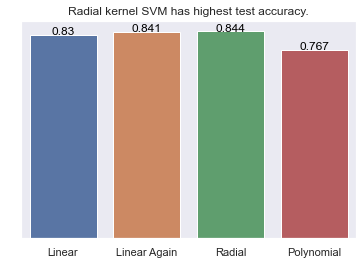

In [134]:
# Create data frame of Model Names and Accuracy scores
df = pd.DataFrame({
    'Models':["Linear","Linear Again","Radial","Polynomial"],
    'Accuracy':[0.830, 0.841, 0.844, 0.767] 
}, columns=['Models', 'Accuracy'])

# bar plot in seaborn
ax = sns.barplot(x="Models", y="Accuracy", data=df, dodge=False)
ax.set_yticks([]) #remove y-axis
ax.set_xlabel(' ')
ax.set_ylabel(' ')
ax.set_title('Radial kernel SVM has highest test accuracy.')
# add values to top of bar
# https://stackoverflow.com/questions/43214978/seaborn-barplot-displaying-values
for index, row in df.iterrows():
    ax.text(row.name,row.Accuracy, round(row.Accuracy,3), color='black', ha="center")

Fine I made the bar chart, but i didn't like it.